Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 7 - ML-based Approaches to Time Series Forecasting

## 7.1 Validation methods for time series

### How to do it...

1. Import the libraries and authenticate:

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

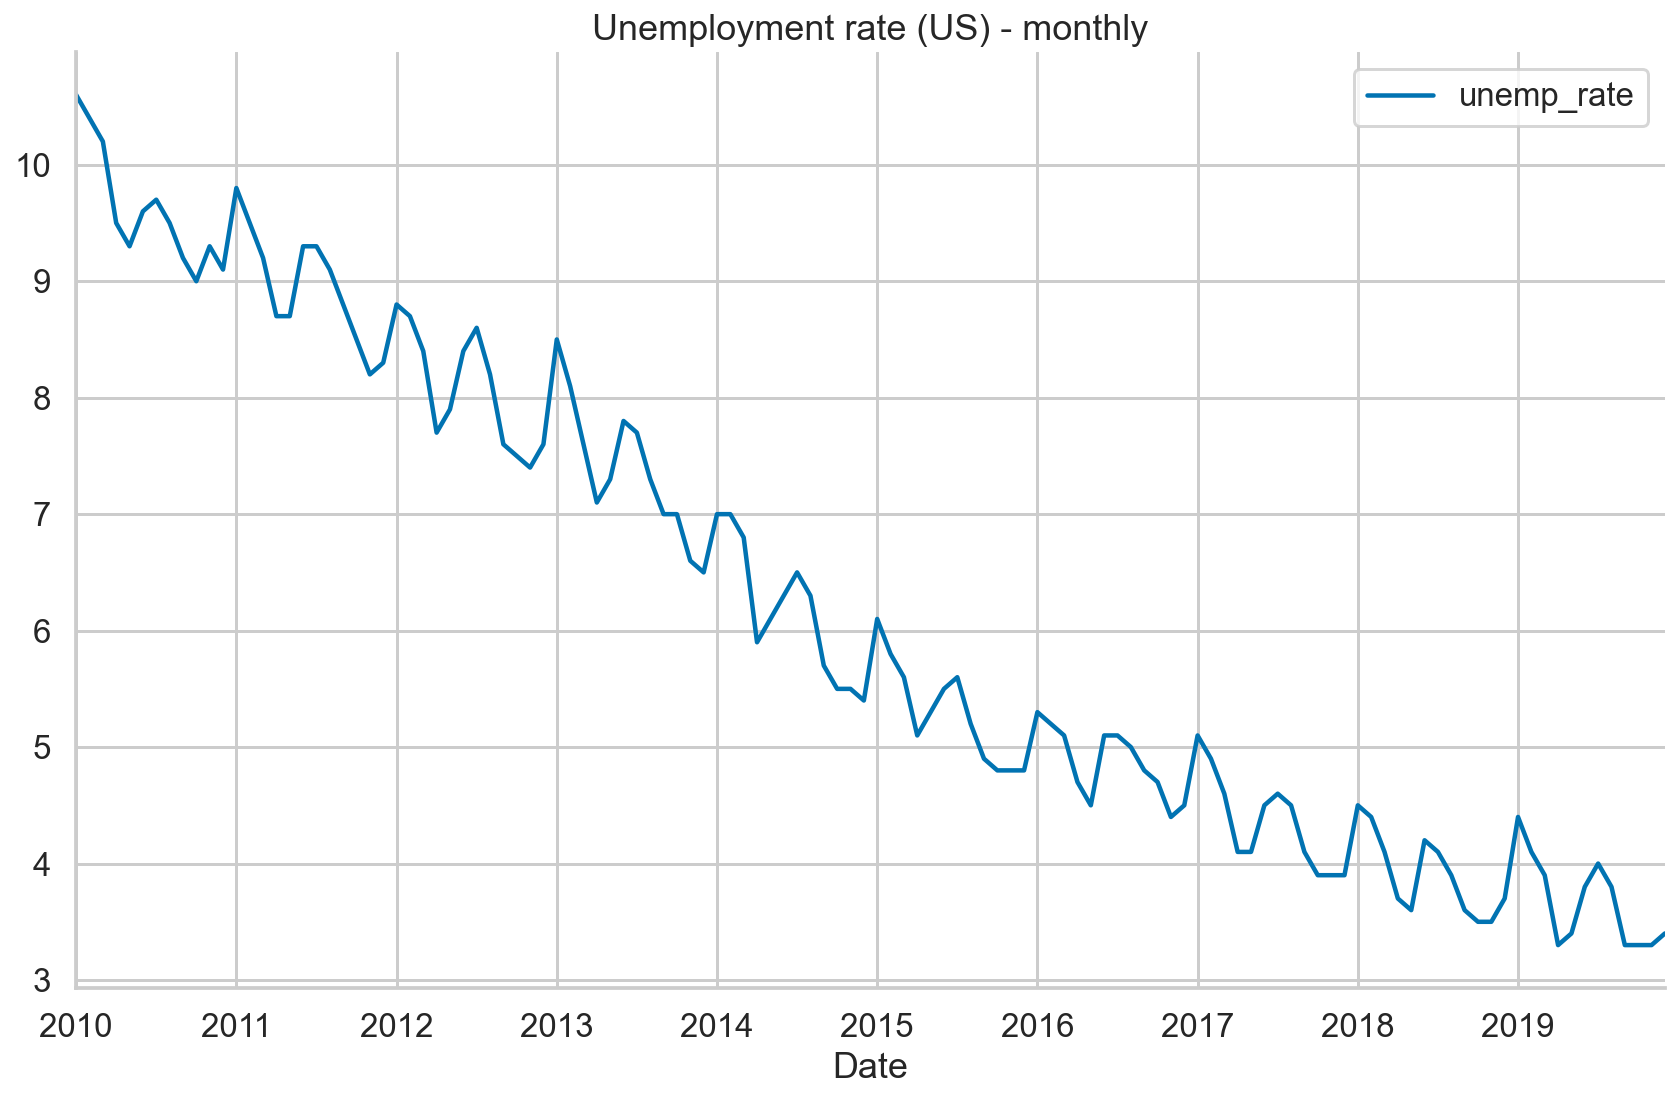

In [4]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
df.plot(title="Unemployment rate (US) - monthly")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_4")

3. Create simple features:

In [5]:
df["linear_trend"] = range(len(df))
df["month"] = df.index.month
df

unemp_rate  linear_trend  month
Date                                       
2010-01-01        10.6             0      1
2010-02-01        10.4             1      2
2010-03-01        10.2             2      3
2010-04-01         9.5             3      4
2010-05-01         9.3             4      5
...                ...           ...    ...
2019-08-01         3.8           115      8
2019-09-01         3.3           116      9
2019-10-01         3.3           117     10
2019-11-01         3.3           118     11
2019-12-01         3.4           119     12

[120 rows x 3 columns]

4. Use one-hot encoding for the month feature:

In [6]:
month_dummies = pd.get_dummies(
    df["month"], drop_first=True, prefix="month"
)

df = df.join(month_dummies) \
       .drop(columns=["month"])

df

unemp_rate  linear_trend  month_2  month_3  month_4  month_5  \
Date                                                                       
2010-01-01        10.6             0        0        0        0        0   
2010-02-01        10.4             1        1        0        0        0   
2010-03-01        10.2             2        0        1        0        0   
2010-04-01         9.5             3        0        0        1        0   
2010-05-01         9.3             4        0        0        0        1   
...                ...           ...      ...      ...      ...      ...   
2019-08-01         3.8           115        0        0        0        0   
2019-09-01         3.3           116        0        0        0        0   
2019-10-01         3.3           117        0        0        0        0   
2019-11-01         3.3           118        0        0        0        0   
2019-12-01         3.4           119        0        0        0        0   

            month_6  month_7  month_8  month_9  month_10  month_11  month_12  
Date                                                                          
2010-01-01        0        0        0        0         0         0         0  
2010-02-01        0        0        0        0         0         0         0  
2010-03-01        0        0        0        0         0         0         0  
2010-04-01        0        0        0        0         0         0         0  
2010-05-01        0        0        0        0         0         0         0  
...             ...      ...      ...      ...       ...       ...       ...  
2019-08-01        0        0        1        0         0         0         0  
2019-09-01        0        0        0        1         0         0         0  
2019-10-01        0        0        0        0         1         0         0  
2019-11-01        0        0        0        0         0         1         0  
2019-12-01        0        0        0        0         0         0         1  

[120 rows x 13 columns]

5. Separate the target from the features:

In [7]:
X = df.copy()
y = X.pop("unemp_rate")

In [8]:
X.shape

(120, 12)

6. Define the expanding window walk-forward validation and print the indices of the folds:

In [9]:
expanding_cv = TimeSeriesSplit(n_splits=5, test_size=12)

for fold, (train_ind, valid_ind) in enumerate(expanding_cv.split(X)):
    print(f"Fold {fold} ----")
    print(f"Train indices: {train_ind}")
    print(f"Valid indices: {valid_ind}")


Fold 0 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Valid indices: [60 61 62 63 64 65 66 67 68 69 70 71]
Fold 1 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Valid indices: [72 73 74 75 76 77 78 79 80 81 82 83]
Fold 2 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Valid indices: [84 85 86 87 88 89 90 91 92 93 94 95]
Fold 3 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23

7. Evaluate the model's performance using the expanding window validation:

In [10]:
scores = [] 

for train_ind, valid_ind in expanding_cv.split(X):
    lr = LinearRegression()
    lr.fit(X.iloc[train_ind], y.iloc[train_ind])
    y_pred = lr.predict(X.iloc[valid_ind])
    scores.append(
        mean_absolute_percentage_error(y.iloc[valid_ind], y_pred)
    )

print(f"Scores: {scores}")
print(f"Avg. score: {np.mean(scores)}")

Scores: [0.03705079312389441, 0.07828415627306308, 0.11981060282173006, 0.16829494012910876, 0.25460459651634165]
Avg. score: 0.1316090177728276


In [11]:
cv_scores = cross_validate(
    LinearRegression(), 
    X, y, 
    cv=expanding_cv, 
    scoring=["neg_mean_absolute_percentage_error", 
             "neg_root_mean_squared_error"]
)
pd.DataFrame(cv_scores)

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.001385    0.000622                                -0.037051   
1  0.001072    0.000649                                -0.078284   
2  0.001062    0.000603                                -0.119811   
3  0.000922    0.000557                                -0.168295   
4  0.000908    0.000544                                -0.254605   

   test_neg_root_mean_squared_error  
0                         -0.232500  
1                         -0.433547  
2                         -0.520073  
3                         -0.662540  
4                         -0.928998

8. Define the sliding window validation and print the indices of the folds:

In [12]:
sliding_cv = TimeSeriesSplit(
    n_splits=5, test_size=12, max_train_size=60
)

for fold, (train_ind, valid_ind) in enumerate(sliding_cv.split(X)):
    print(f"Fold {fold} ----")
    print(f"Train indices: {train_ind}")
    print(f"Valid indices: {valid_ind}")


Fold 0 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Valid indices: [60 61 62 63 64 65 66 67 68 69 70 71]
Fold 1 ----
Train indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71]
Valid indices: [72 73 74 75 76 77 78 79 80 81 82 83]
Fold 2 ----
Train indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Valid indices: [84 85 86 87 88 89 90 91 92 93 94 95]
Fold 3 ----
Train indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 9

9. Evaluate the model's performance using the sliding window validation:

In [13]:
cv_scores = cross_validate(
    LinearRegression(), 
    X, y, 
    cv=sliding_cv, 
    scoring=["neg_mean_absolute_percentage_error", 
             "neg_root_mean_squared_error"]
)
pd.DataFrame(cv_scores)

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.001556    0.000682                                -0.037051   
1  0.000940    0.000559                                -0.097125   
2  0.000911    0.000755                                -0.126609   
3  0.000958    0.000573                                -0.129454   
4  0.000906    0.000570                                -0.108759   

   test_neg_root_mean_squared_error  
0                         -0.232500  
1                         -0.524333  
2                         -0.550749  
3                         -0.518194  
4                         -0.407428

In [14]:
-1 * cv_scores["test_neg_mean_absolute_percentage_error"].mean()

0.09979962624891436

## 7.2 Feature engineering for time series

### How to do it...

1. Import the libraries:

In [3]:
import numpy as np
import pandas as pd
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklego.preprocessing import RepeatingBasisFunction

In [4]:
# temporary change for this recipe
sns.set_palette(["grey", "blue"])

2. Generate a time series with repeating patterns:

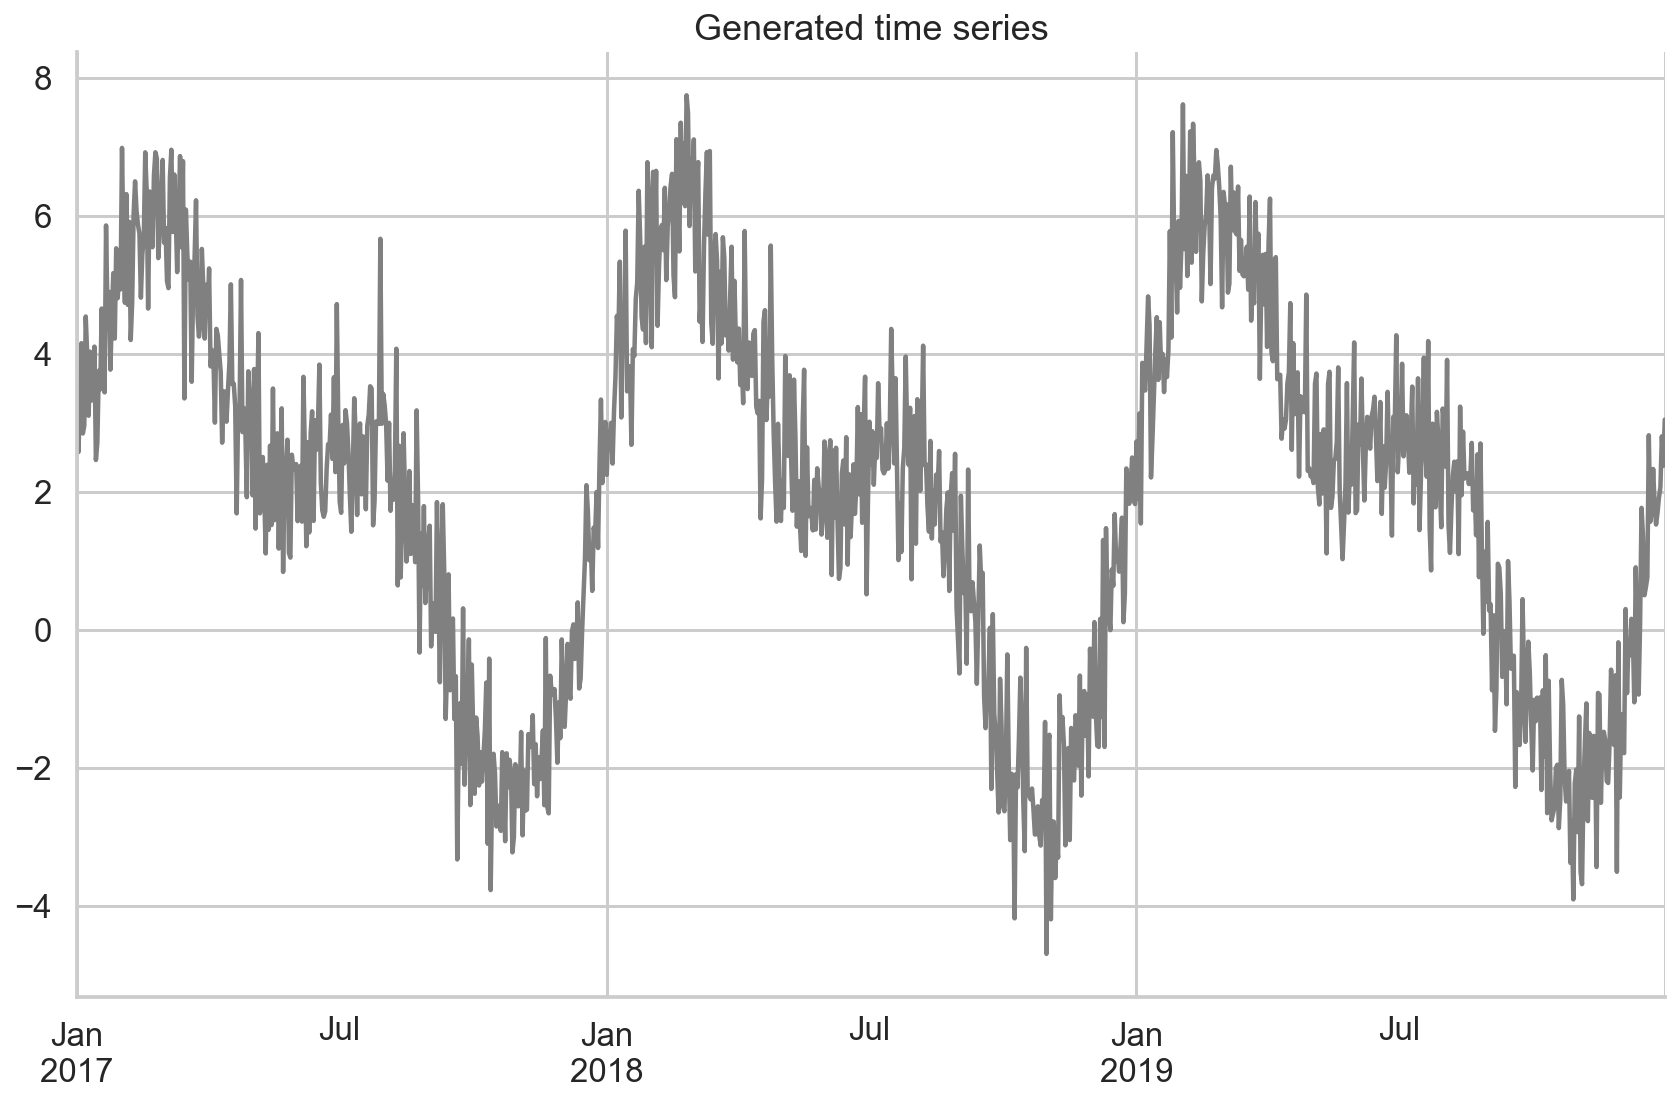

In [5]:
np.random.seed(42)

range_of_dates = pd.date_range(start="2017-01-01", 
                               end="2019-12-31")
X = pd.DataFrame(index=range_of_dates)

X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year

signal_1 = 2 + 3 * np.sin(X["day_nr"] / 365 * 2 * np.pi)
signal_2 = 2 * np.sin(X["day_nr"] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.81, len(X))

y = signal_1 + signal_2 + noise
y.name = "y"

y.plot(title="Generated time series")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_10")

In [6]:
X

day_nr  day_of_year
2017-01-01       0            1
2017-01-02       1            2
2017-01-03       2            3
2017-01-04       3            4
2017-01-05       4            5
...            ...          ...
2019-12-27    1090          361
2019-12-28    1091          362
2019-12-29    1092          363
2019-12-30    1093          364
2019-12-31    1094          365

[1095 rows x 2 columns]

3. Store the time series in a new DataFrame:

In [7]:
results_df = y.to_frame()
results_df.columns = ["y_true"]
results_df.head()

y_true
2017-01-01  2.969692
2017-01-02  2.572678
2017-01-03  3.325853
2017-01-04  4.150575
2017-01-05  2.842004

4. Encode the month information as dummies:

In [8]:
X_1 = pd.get_dummies(
    X.index.month, drop_first=True, prefix="month"
)
X_1.index = X.index
X_1

month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2017-01-01        0        0        0        0        0        0        0   
2017-01-02        0        0        0        0        0        0        0   
2017-01-03        0        0        0        0        0        0        0   
2017-01-04        0        0        0        0        0        0        0   
2017-01-05        0        0        0        0        0        0        0   
...             ...      ...      ...      ...      ...      ...      ...   
2019-12-27        0        0        0        0        0        0        0   
2019-12-28        0        0        0        0        0        0        0   
2019-12-29        0        0        0        0        0        0        0   
2019-12-30        0        0        0        0        0        0        0   
2019-12-31        0        0        0        0        0        0        0   

            month_9  month_10  month_11  month_12  
2017-01-01        0         0         0         0  
2017-01-02        0         0         0         0  
2017-01-03        0         0         0         0  
2017-01-04        0         0         0         0  
2017-01-05        0         0         0         0  
...             ...       ...       ...       ...  
2019-12-27        0         0         0         1  
2019-12-28        0         0         0         1  
2019-12-29        0         0         0         1  
2019-12-30        0         0         0         1  
2019-12-31        0         0         0         1  

[1095 rows x 11 columns]

5. Fit a linear regression model and plot the in-sample prediction:

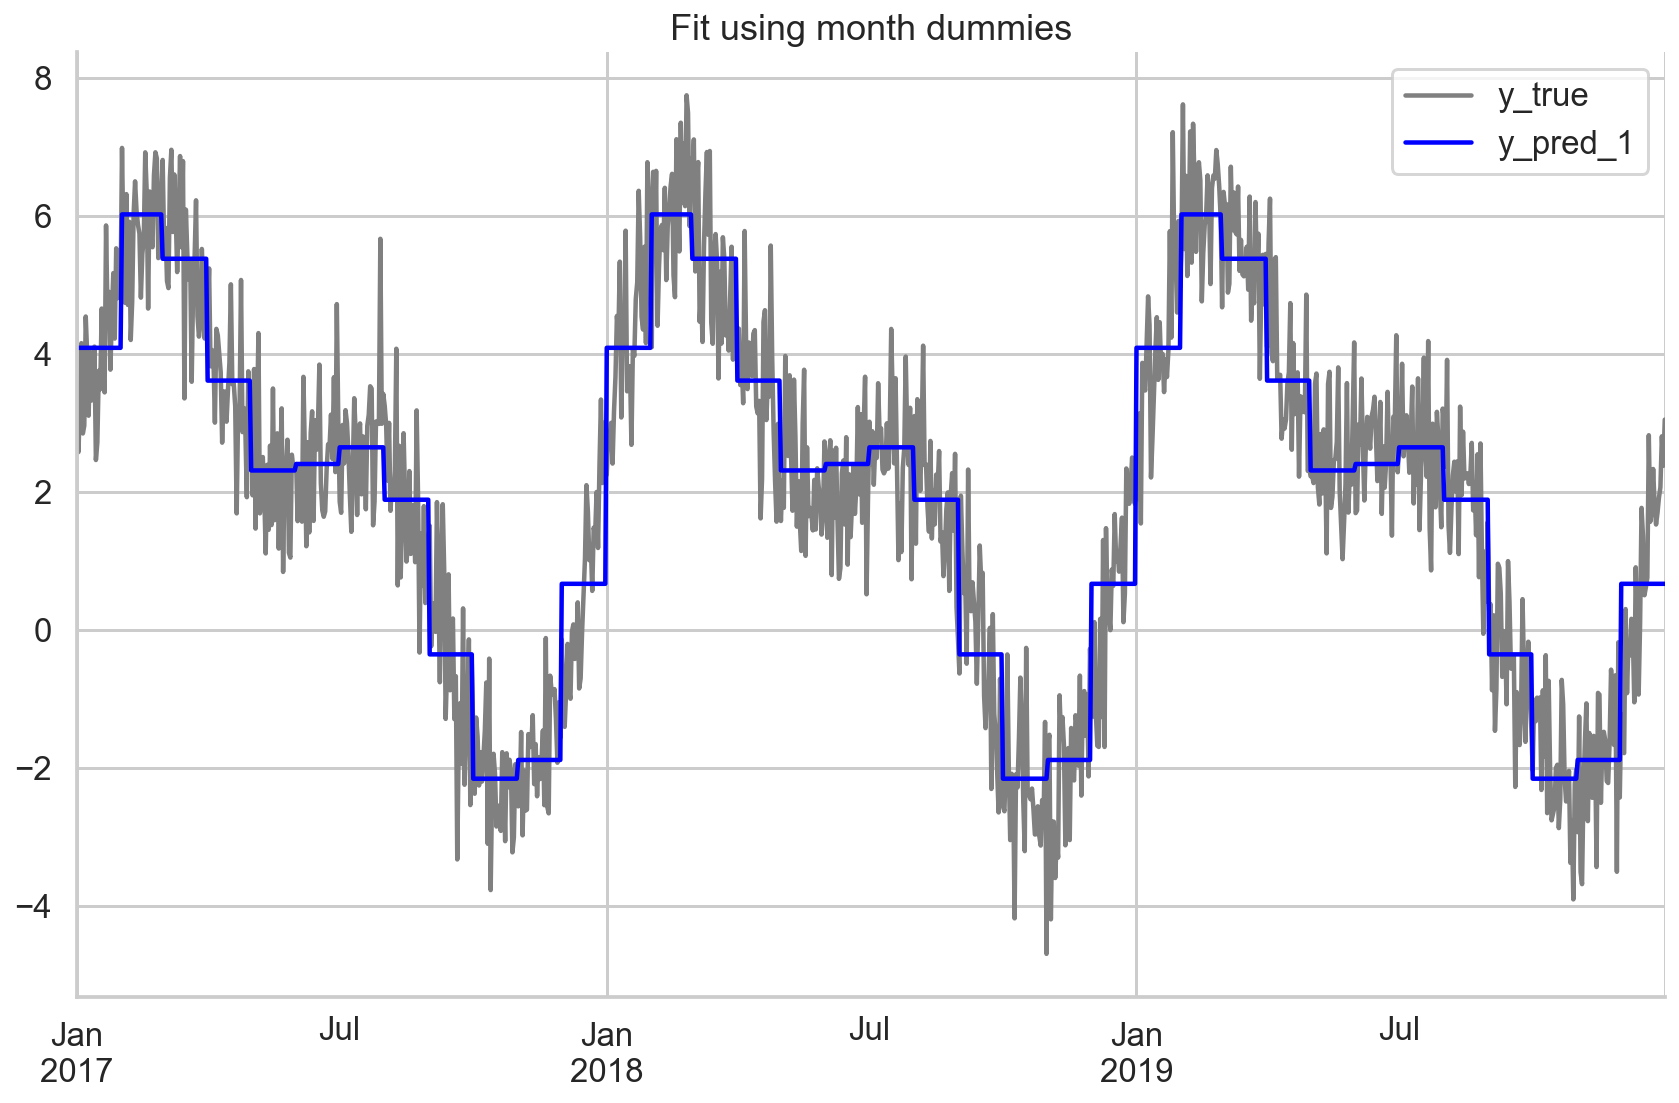

In [9]:
model_1 = LinearRegression().fit(X_1, y)

results_df["y_pred_1"] = model_1.predict(X_1)
(
    results_df[["y_true", "y_pred_1"]]
    .plot(title="Fit using month dummies")
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_12")

6. Define functions used for creating the cyclical encoding:

In [10]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

7. Encode the month and day information using cyclical encoding:

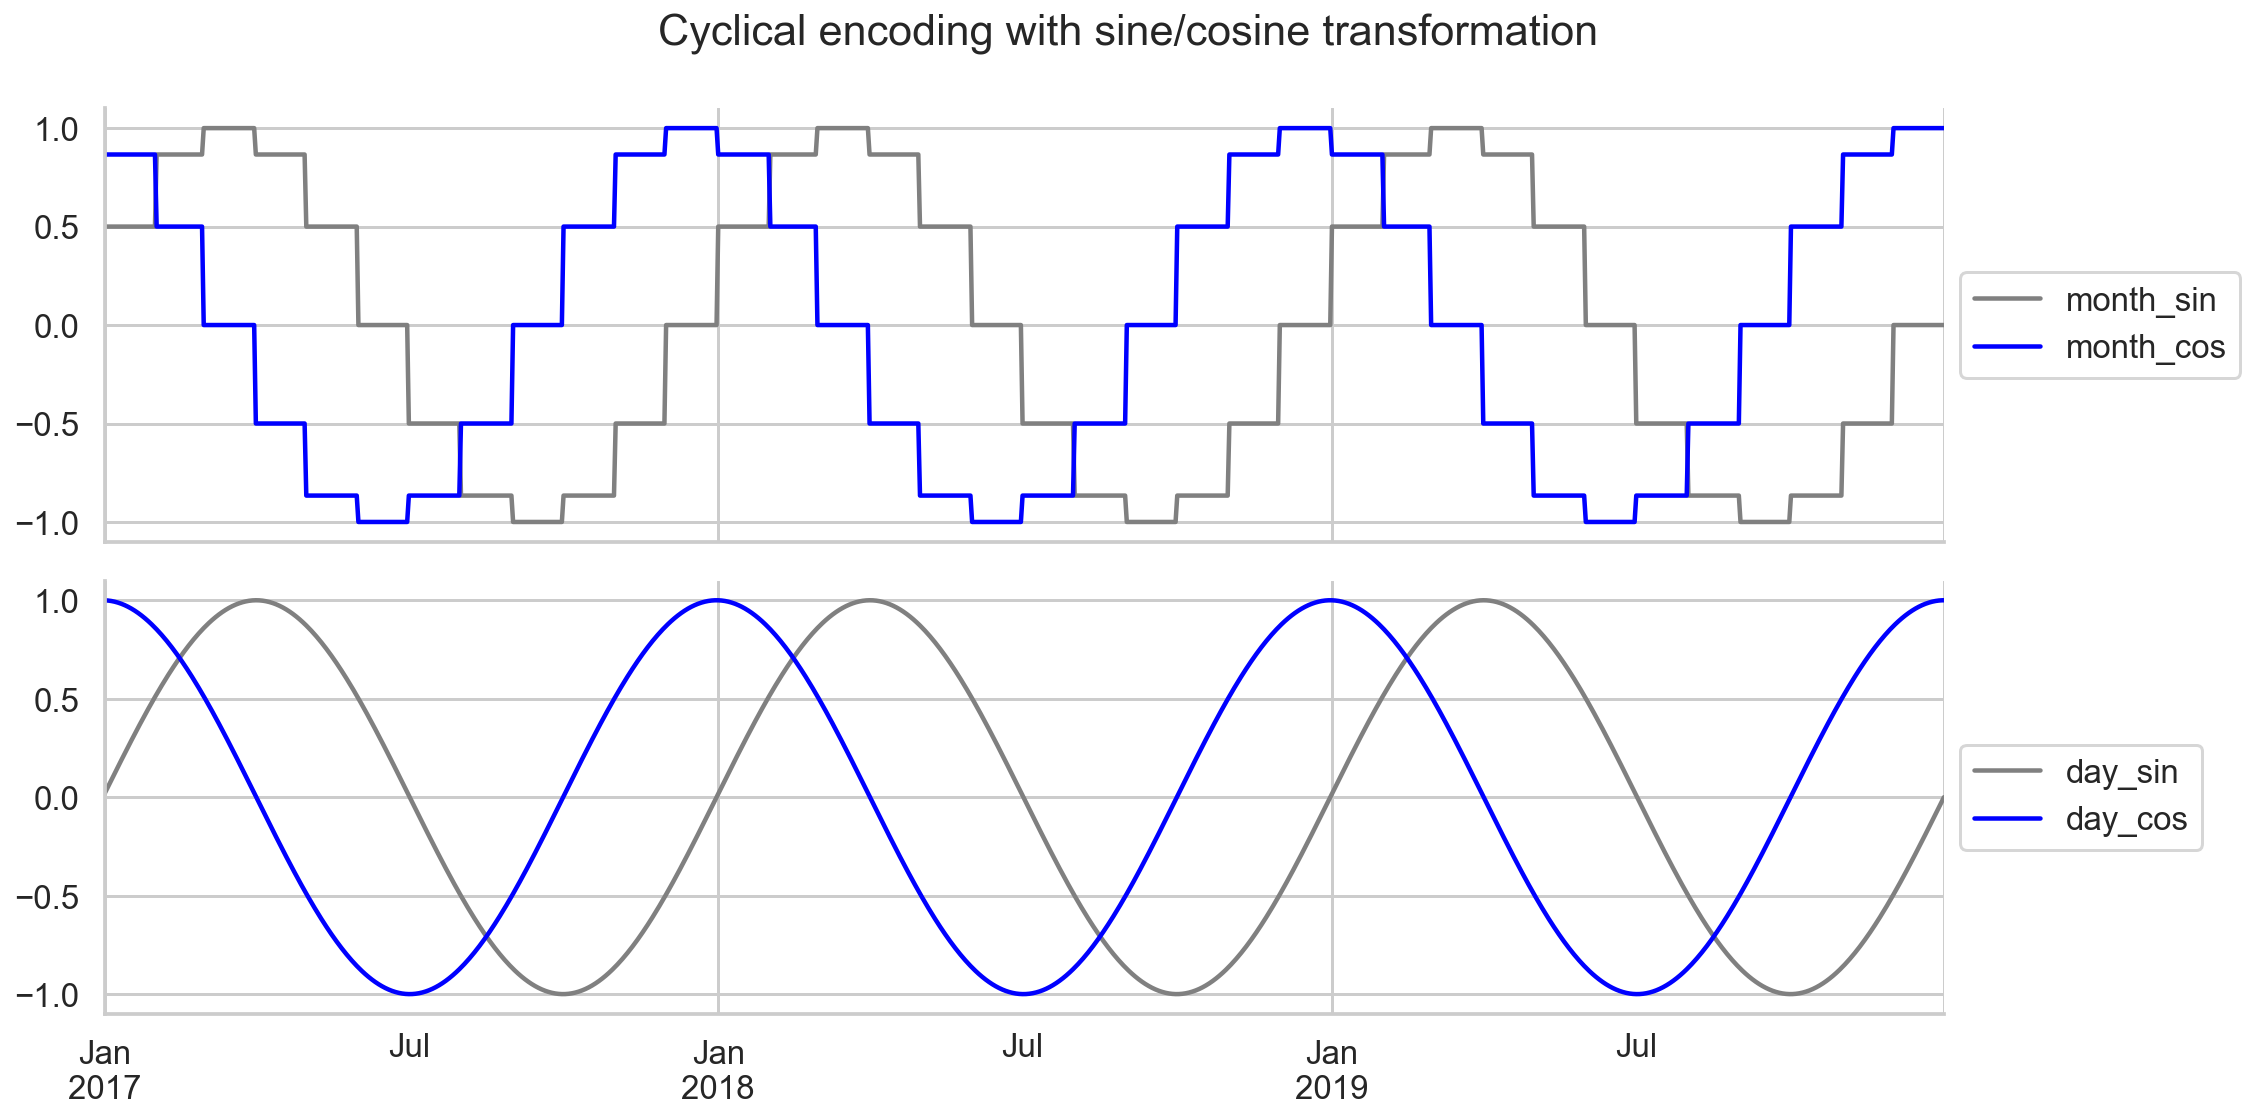

In [11]:
X_2 = X.copy()
X_2["month"] = X_2.index.month

X_2["month_sin"] = sin_transformer(12).fit_transform(X_2)["month"]
X_2["month_cos"] = cos_transformer(12).fit_transform(X_2)["month"]

X_2["day_sin"] = sin_transformer(365).fit_transform(X_2)["day_of_year"]
X_2["day_cos"] = cos_transformer(365).fit_transform(X_2)["day_of_year"]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,8))
X_2[["month_sin", "month_cos"]].plot(ax=ax[0])
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
X_2[["day_sin", "day_cos"]].plot(ax=ax[1])
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle("Cyclical encoding with sine/cosine transformation")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_13")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


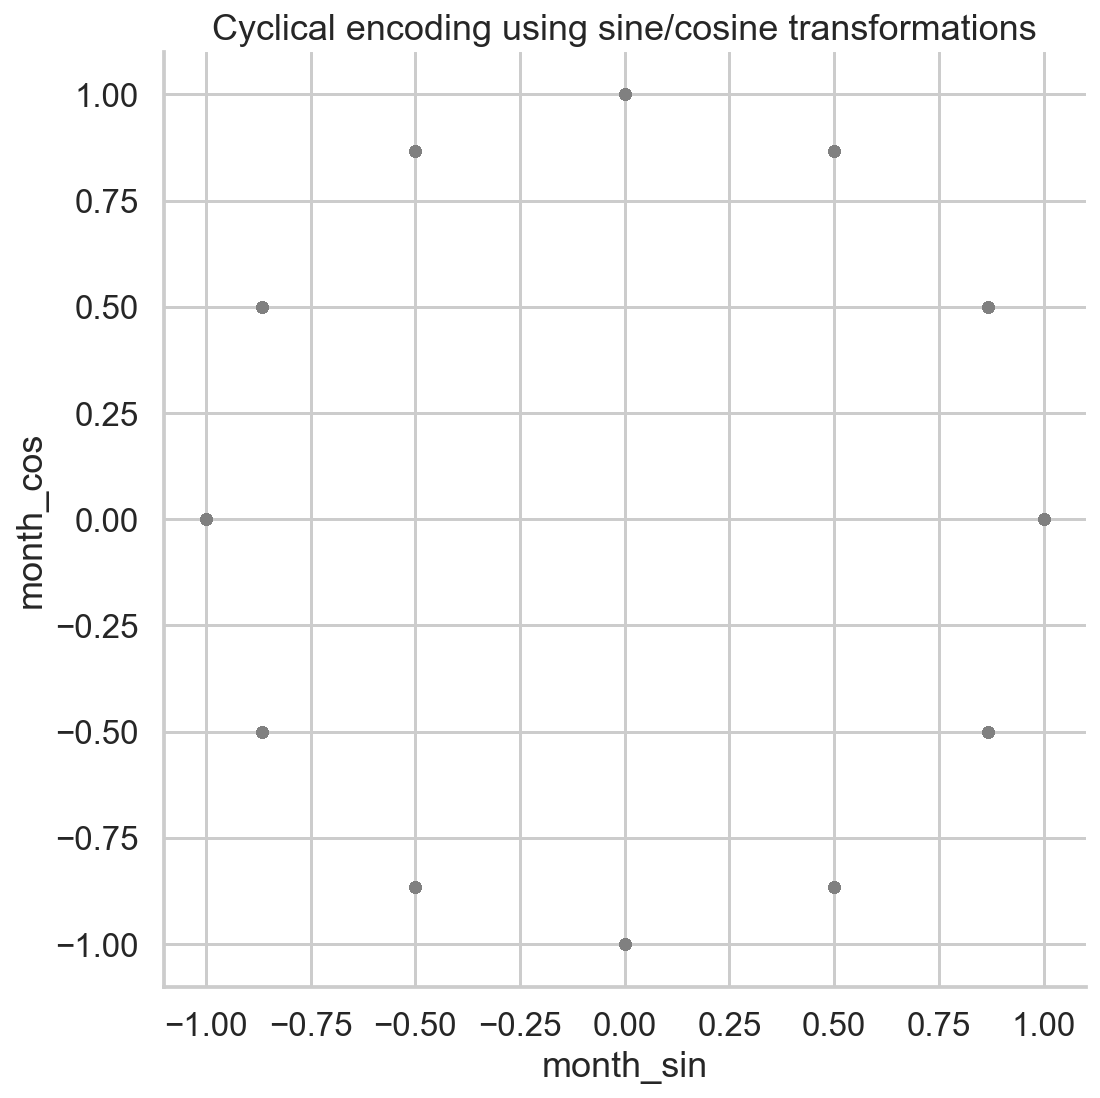

In [12]:
(
    X_2[X_2.index.year == 2017]
    .plot(
        kind="scatter", 
        x="month_sin", 
        y="month_cos", 
        figsize=(8, 8),
        title="Cyclical encoding using sine/cosine transformations"
    )
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_14")

8. Fit a model using the daily sine/cosine features:

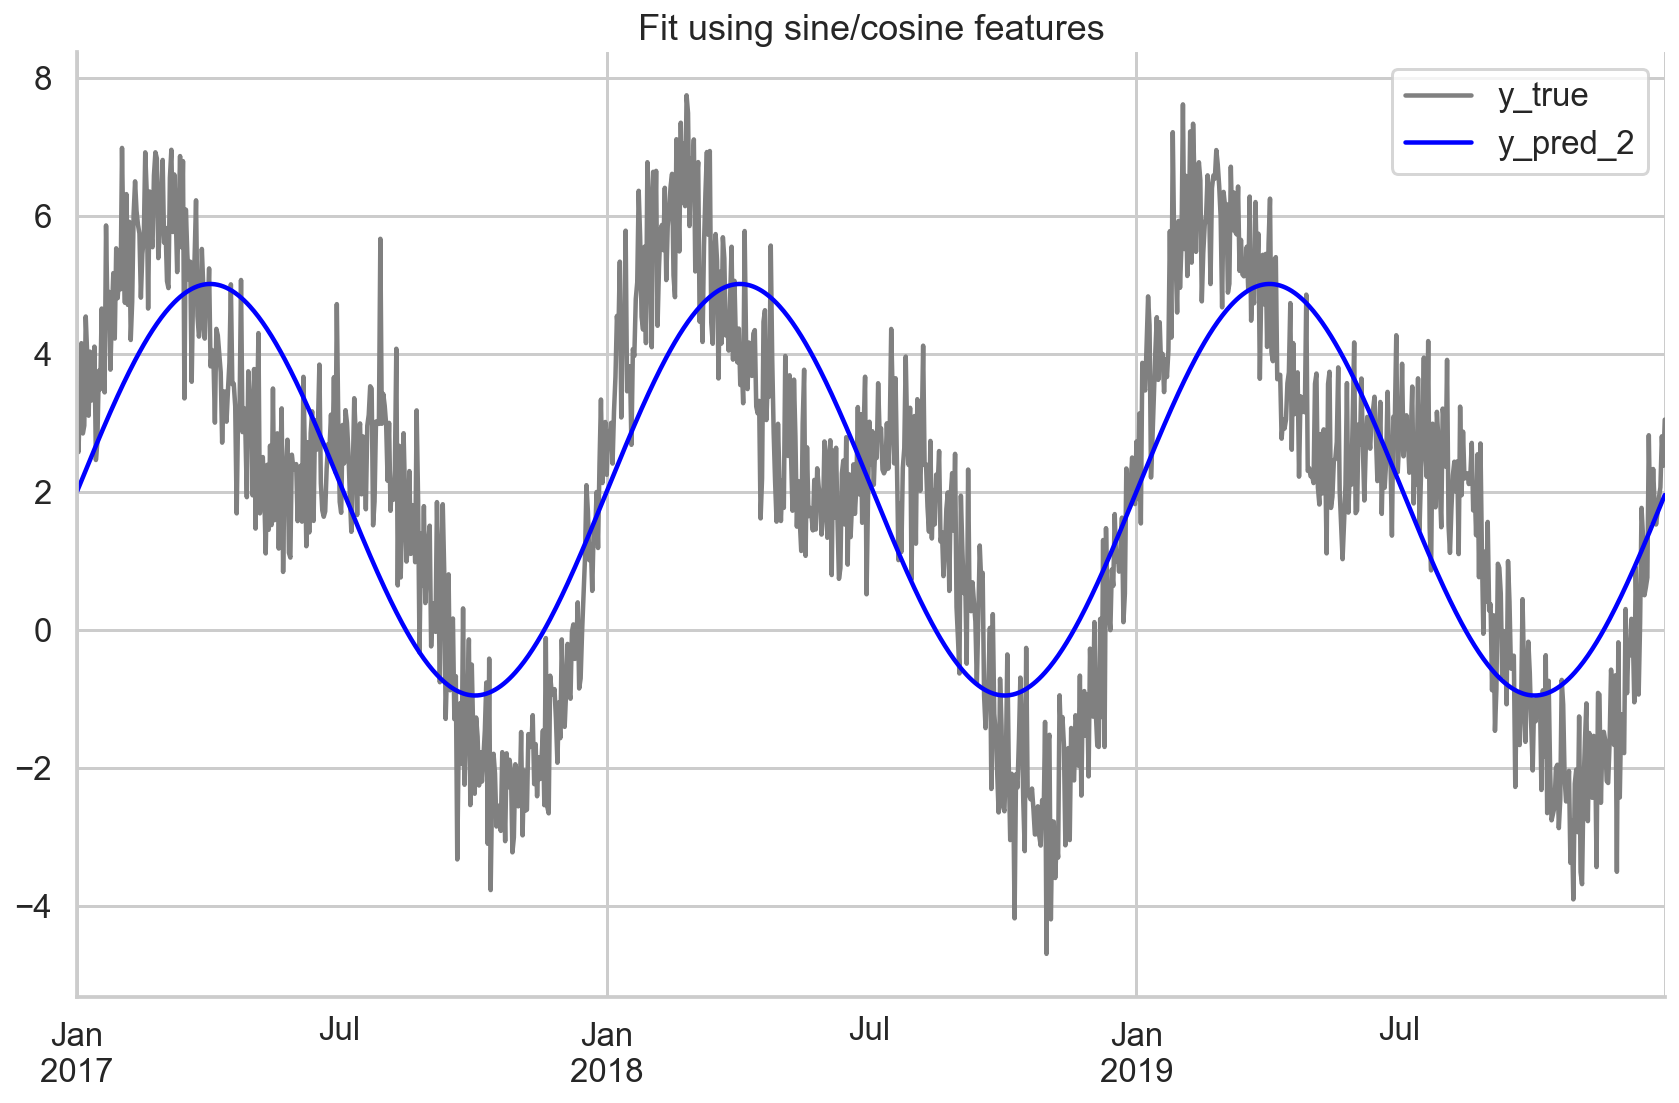

In [13]:
X_2 = X_2[["day_sin", "day_cos"]]

model_2 = LinearRegression().fit(X_2, y)

results_df["y_pred_2"] = model_2.predict(X_2)
(
    results_df[["y_true", "y_pred_2"]]
    .plot(title="Fit using sine/cosine features")
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_15")

9. Create features using the radial basis functions:

In [14]:
rbf = RepeatingBasisFunction(n_periods=12,
                             column="day_of_year",
                             input_range=(1,365),
                             remainder="drop")
rbf.fit(X)
X_3 = pd.DataFrame(index=X.index, 
                   data=rbf.transform(X))

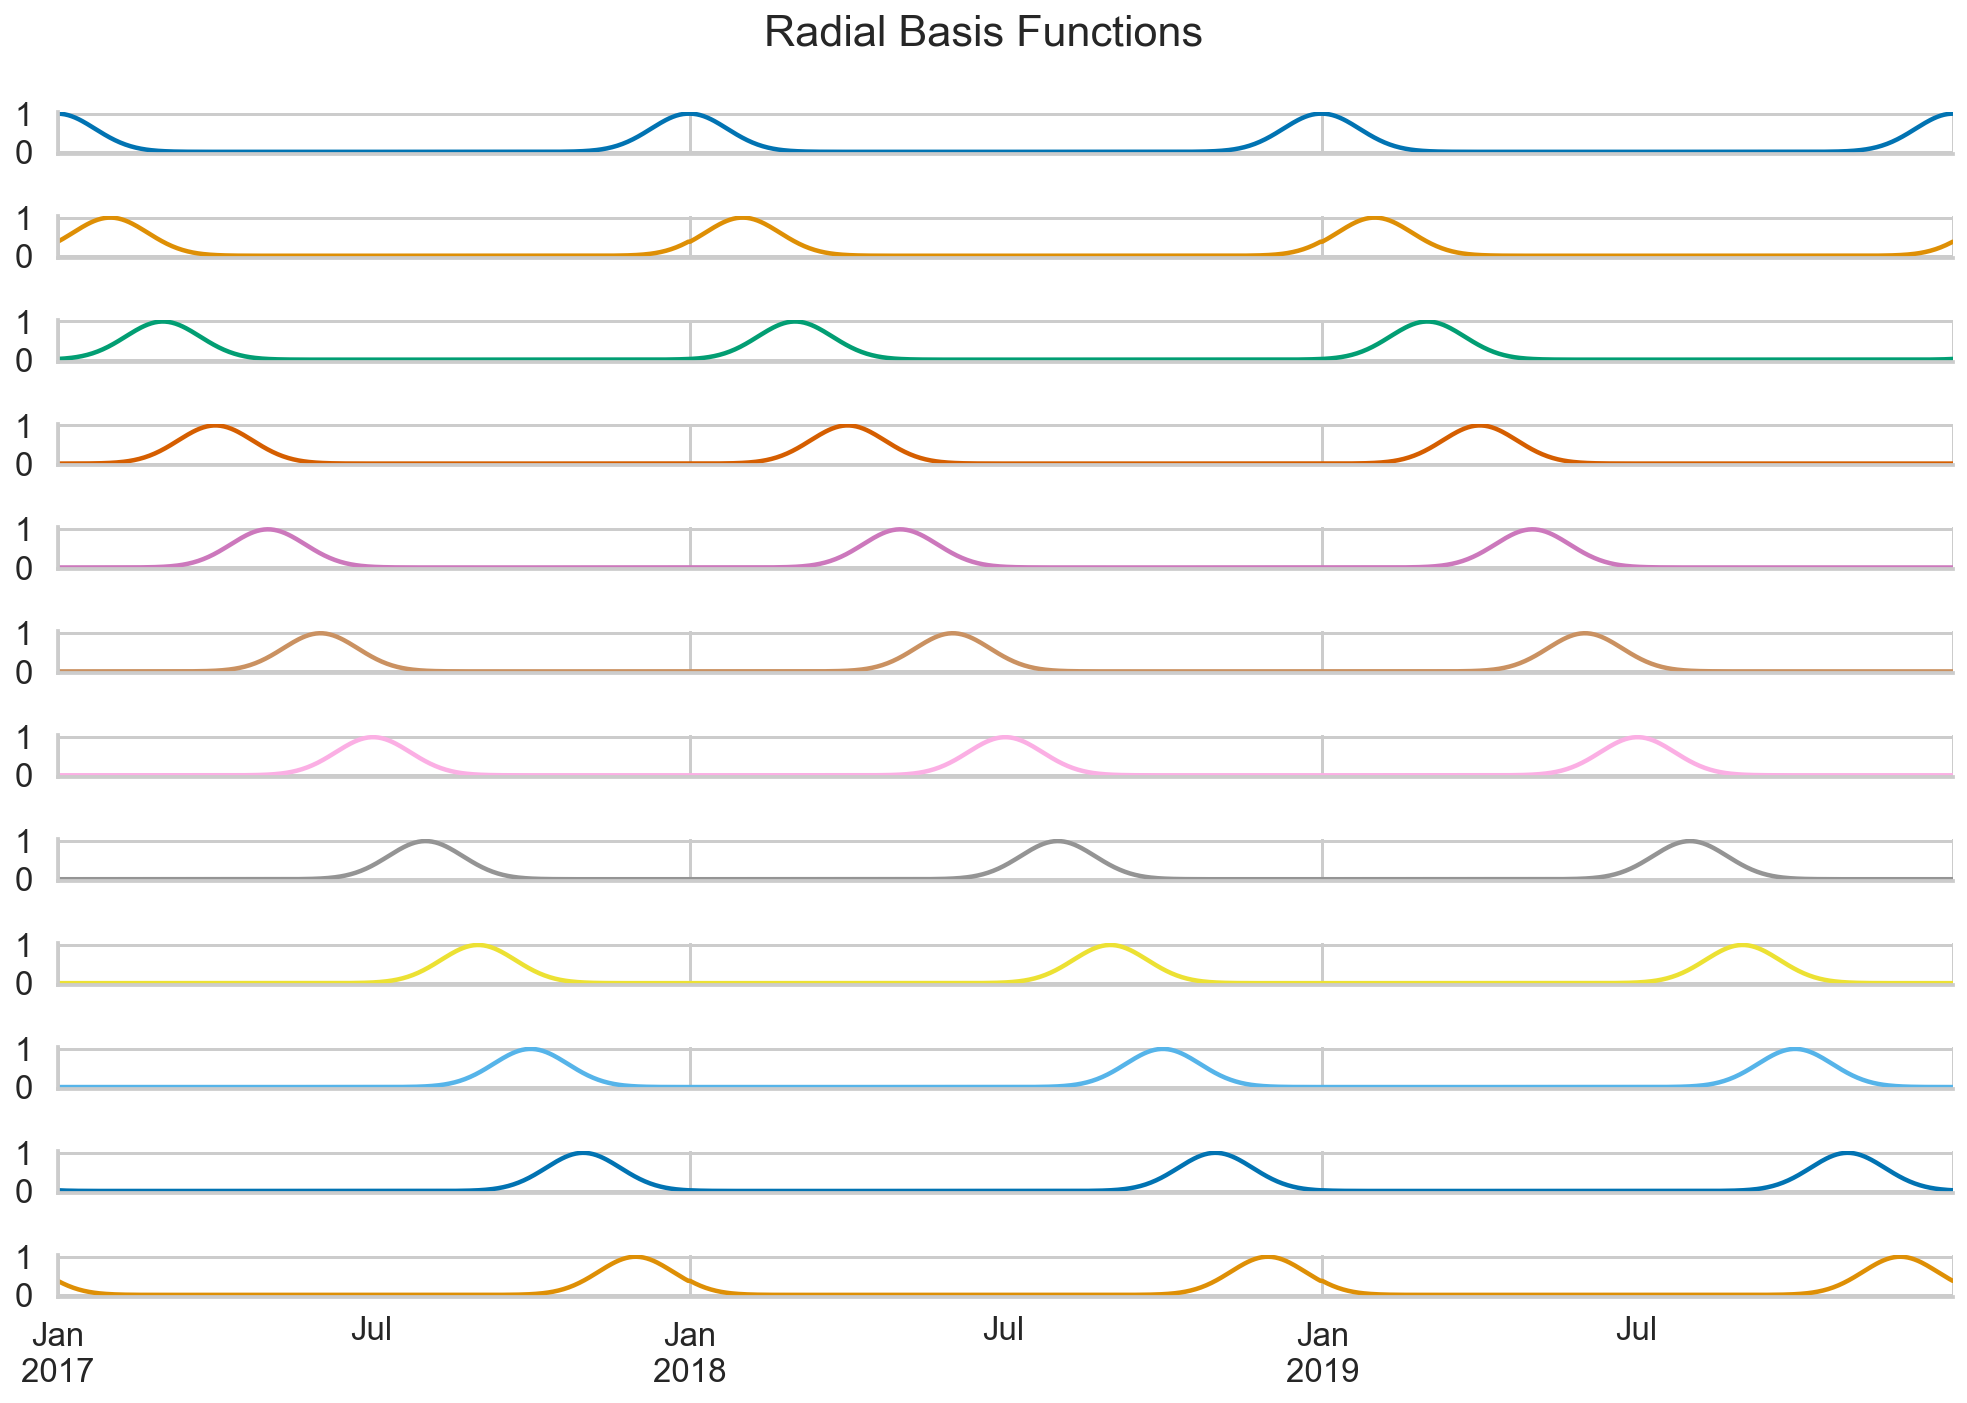

In [18]:
X_3.plot(subplots=True, sharex=True, 
         title="Radial Basis Functions", 
         legend=False, figsize=(14, 10))

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_16")

10. Fit a model using the RBF features:

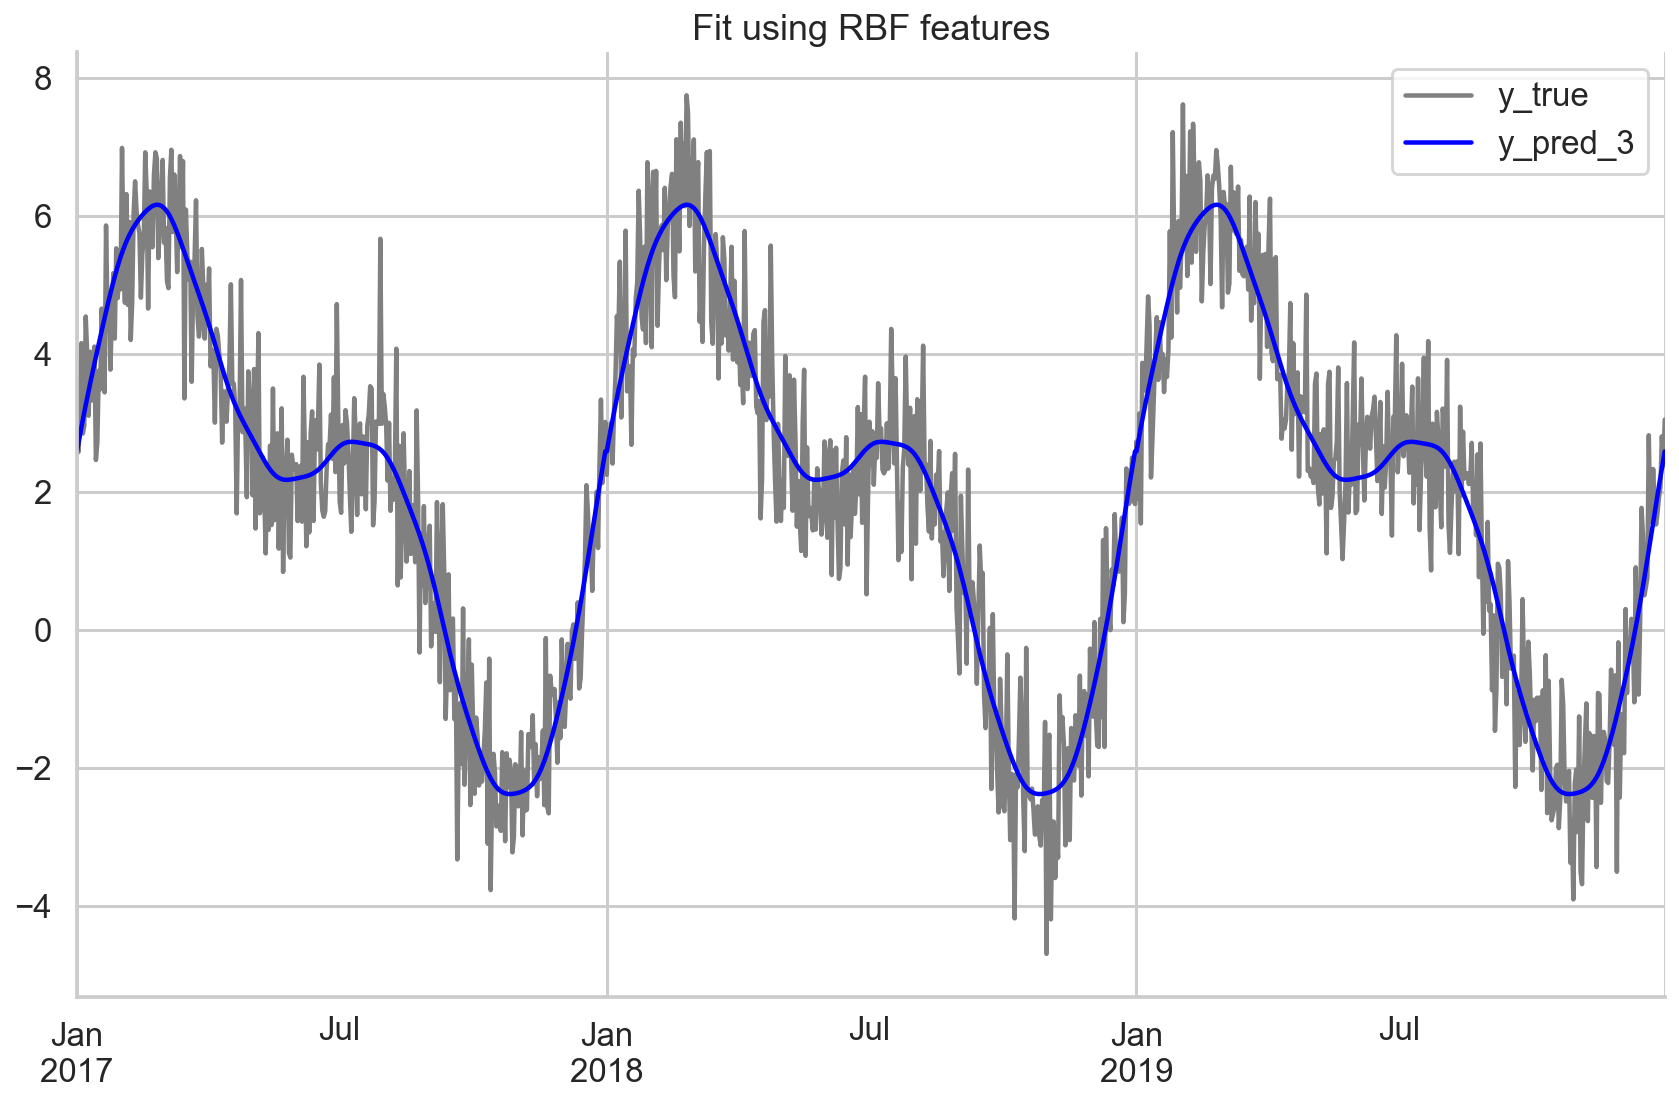

In [16]:
model_3 = LinearRegression().fit(X_3, y)

results_df["y_pred_3"] = model_3.predict(X_3)
(
    results_df[["y_true", "y_pred_3"]]
    .plot(title="Fit using RBF features")
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_17")

### There's more

1. Import the libraries:

In [ ]:
from sktime.transformations.series.date import DateTimeFeatures

from tsfresh import extract_features
from tsfresh.feature_extraction import settings
from tsfresh.utilities.dataframe_functions import roll_time_series

2. Extract the datetime-features using `sktime`:

In [ ]:
dt_features = DateTimeFeatures(
    ts_freq="D", feature_scope="comprehensive"
)
features_df_1 = dt_features.fit_transform(y)
features_df_1.head()

y  year  quarter  month  week_of_year  day  \
2017-01-01  2.969692  2017        1      1            52    1   
2017-01-02  2.572678  2017        1      1             1    2   
2017-01-03  3.325853  2017        1      1             1    3   
2017-01-04  4.150575  2017        1      1             1    4   
2017-01-05  2.842004  2017        1      1             1    5   

            month_of_quarter  week_of_quarter  day_of_quarter  week_of_month  \
2017-01-01                 1                1               1              1   
2017-01-02                 1                2               2              1   
2017-01-03                 1                2               3              1   
2017-01-04                 1                2               4              1   
2017-01-05                 1                2               5              1   

            day  weekday  
2017-01-01    1        6  
2017-01-02    2        0  
2017-01-03    3        1  
2017-01-04    4        2  
2017-01-05    5        3

3. Prepare the dataset for feature extraction with `tsfresh`:

In [ ]:
df = y.to_frame().reset_index(drop=False)
df.columns = ["date", "y"]
df["series_id"] = "a"
df

date         y series_id
0    2017-01-01  2.969692         a
1    2017-01-02  2.572678         a
2    2017-01-03  3.325853         a
3    2017-01-04  4.150575         a
4    2017-01-05  2.842004         a
...         ...       ...       ...
1090 2019-12-27  1.914564         a
1091 2019-12-28  2.062146         a
1092 2019-12-29  2.801118         a
1093 2019-12-30  2.372868         a
1094 2019-12-31  3.042800         a

[1095 rows x 3 columns]

4. Create a rolled-up DataFrame for feature extraction:

In [ ]:
df_rolled = roll_time_series(
    df, column_id="series_id", column_sort="date",
    max_timeshift=30, min_timeshift=7
).drop(columns=["series_id"])
df_rolled

Rolling: 100%|██████████| 20/20 [00:01<00:00, 12.30it/s]


date         y                        id
3410  2017-01-01  2.969692  (a, 2017-01-08 00:00:00)
3411  2017-01-02  2.572678  (a, 2017-01-08 00:00:00)
3412  2017-01-03  3.325853  (a, 2017-01-08 00:00:00)
3413  2017-01-04  4.150575  (a, 2017-01-08 00:00:00)
3414  2017-01-05  2.842004  (a, 2017-01-08 00:00:00)
...          ...       ...                       ...
33447 2019-12-27  1.914564  (a, 2019-12-31 00:00:00)
33448 2019-12-28  2.062146  (a, 2019-12-31 00:00:00)
33449 2019-12-29  2.801118  (a, 2019-12-31 00:00:00)
33450 2019-12-30  2.372868  (a, 2019-12-31 00:00:00)
33451 2019-12-31  3.042800  (a, 2019-12-31 00:00:00)

[33452 rows x 3 columns]

5. Extract the minimal set of features:

In [ ]:
settings_minimal = settings.MinimalFCParameters() 
settings_minimal

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

In [ ]:
features_df_2 = extract_features(
    df_rolled, column_id="id", 
    column_sort="date", 
    default_fc_parameters=settings_minimal
)

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.87it/s]


In [ ]:
features_df_2

y__sum_values  y__median   y__mean  y__length  \
a 2017-01-08      27.344582   3.147773  3.418073        8.0   
  2017-01-09      30.443686   3.099104  3.382632        9.0   
  2017-01-10      34.471211   3.212478  3.447121       10.0   
  2017-01-11      37.791096   3.319885  3.435554       11.0   
  2017-01-12      41.214759   3.322869  3.434563       12.0   
...                     ...        ...       ...        ...   
  2019-12-27       6.536710   0.155974  0.210862       31.0   
  2019-12-28       9.261894   0.297687  0.298771       31.0   
  2019-12-29      15.572855   0.497914  0.502350       31.0   
  2019-12-30      18.129833   0.614783  0.584833       31.0   
  2019-12-31      23.606241   0.755187  0.761492       31.0   

              y__standard_deviation  y__variance  y__maximum  y__minimum  
a 2017-01-08               0.669595     0.448357    4.537116    2.572678  
  2017-01-09               0.639209     0.408588    4.537116    2.572678  
  2017-01-10               0.636521     0.405159    4.537116    2.572678  
  2017-01-11               0.608001     0.369665    4.537116    2.572678  
  2017-01-12               0.582125     0.338870    4.537116    2.572678  
...                             ...          ...         ...         ...  
  2019-12-27               1.459941     2.131428    2.816481   -3.509843  
  2019-12-28               1.486480     2.209621    2.816481   -3.509843  
  2019-12-29               1.379220     1.902248    2.816481   -2.433608  
  2019-12-30               1.411775     1.993109    2.816481   -2.433608  
  2019-12-31               1.364877     1.862889    3.042800   -1.789771  

[1088 rows x 8 columns]

6. Clean up the index and inspect the features:

In [ ]:
features_df_2 = (
    features_df_2
    .set_index(
        features_df_2.index.map(lambda x: x[1]), drop=True
    )
)
features_df_2.index.name = "last_date"
features_df_2.head(25).round(4)

y__sum_values  y__median  y__mean  y__length  \
last_date                                                  
2017-01-08        27.3446     3.1478   3.4181        8.0   
2017-01-09        30.4437     3.0991   3.3826        9.0   
2017-01-10        34.4712     3.2125   3.4471       10.0   
2017-01-11        37.7911     3.3199   3.4356       11.0   
2017-01-12        41.2148     3.3229   3.4346       12.0   
2017-01-13        45.3157     3.3259   3.4858       13.0   
2017-01-14        47.7731     3.3229   3.4124       14.0   
2017-01-15        50.4837     3.3199   3.3656       15.0   
2017-01-16        54.2347     3.3229   3.3897       16.0   
2017-01-17        57.7174     3.3259   3.3951       17.0   
2017-01-18        62.3698     3.3748   3.4650       18.0   
2017-01-19        66.1248     3.4237   3.4803       19.0   
2017-01-20        69.5618     3.4304   3.4781       20.0   
2017-01-21        75.4183     3.4370   3.5913       21.0   
2017-01-22        79.9908     3.4599   3.6359       22.0   
2017-01-23        84.8846     3.4827   3.6906       23.0   
2017-01-24        88.6509     3.6168   3.6938       24.0   
2017-01-25        93.2093     3.7510   3.7284       25.0   
2017-01-26        98.3749     3.7530   3.7836       26.0   
2017-01-27       102.5922     3.7550   3.7997       27.0   
2017-01-28       108.1175     3.7607   3.8613       28.0   
2017-01-29       112.9206     3.7664   3.8938       29.0   
2017-01-30       118.0400     3.8787   3.9347       30.0   
2017-01-31       122.9716     3.9909   3.9668       31.0   
2017-02-01       126.9819     4.0275   4.0962       31.0   

            y__standard_deviation  y__variance  y__maximum  y__minimum  
last_date                                                               
2017-01-08                 0.6696       0.4484      4.5371      2.5727  
2017-01-09                 0.6392       0.4086      4.5371      2.5727  
2017-01-10                 0.6365       0.4052      4.5371      2.5727  
2017-01-11                 0.6080       0.3697      4.5371      2.5727  
2017-01-12                 0.5821       0.3389      4.5371      2.5727  
2017-01-13                 0.5868       0.3443      4.5371      2.5727  
2017-01-14                 0.6244       0.3899      4.5371      2.4575  
2017-01-15                 0.6281       0.3945      4.5371      2.4575  
2017-01-16                 0.6153       0.3786      4.5371      2.4575  
2017-01-17                 0.5973       0.3568      4.5371      2.4575  
2017-01-18                 0.6480       0.4199      4.6524      2.4575  
2017-01-19                 0.6340       0.4020      4.6524      2.4575  
2017-01-20                 0.6180       0.3820      4.6524      2.4575  
2017-01-21                 0.7876       0.6203      5.8565      2.4575  
2017-01-22                 0.7962       0.6339      5.8565      2.4575  
2017-01-23                 0.8198       0.6721      5.8565      2.4575  
2017-01-24                 0.8027       0.6444      5.8565      2.4575  
2017-01-25                 0.8045       0.6473      5.8565      2.4575  
2017-01-26                 0.8359       0.6988      5.8565      2.4575  
2017-01-27                 0.8244       0.6796      5.8565      2.4575  
2017-01-28                 0.8706       0.7579      5.8565      2.4575  
2017-01-29                 0.8725       0.7613      5.8565      2.4575  
2017-01-30                 0.8856       0.7843      5.8565      2.4575  
2017-01-31                 0.8888       0.7900      5.8565      2.4575  
2017-02-01                 1.0169       1.0341      6.9799      2.4575

## 7.3 Time series forecasting as reduced regression

### Getting ready

1. Import the libraries and authenticate:

In [3]:
import pandas as pd
import numpy as np
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [4]:
y = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
y.index = y.index.to_period(freq="M")

In [5]:
y

unemp_rate
Date               
2010-01        10.6
2010-02        10.4
2010-03        10.2
2010-04         9.5
2010-05         9.3
...             ...
2019-08         3.8
2019-09         3.3
2019-10         3.3
2019-11         3.3
2019-12         3.4

[120 rows x 1 columns]

### How to do it...

1. Import the libraries:

In [6]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    temporal_train_test_split, ExpandingWindowSplitter
)
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    make_reduction, TransformedTargetForecaster, 
    EnsembleForecaster
)
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error
)
from sktime.transformations.series.detrend import (
    Deseasonalizer, Detrender
)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.arima import AutoARIMA

from sklearn.ensemble import RandomForestRegressor

2. Split the time series into training and tests sets:

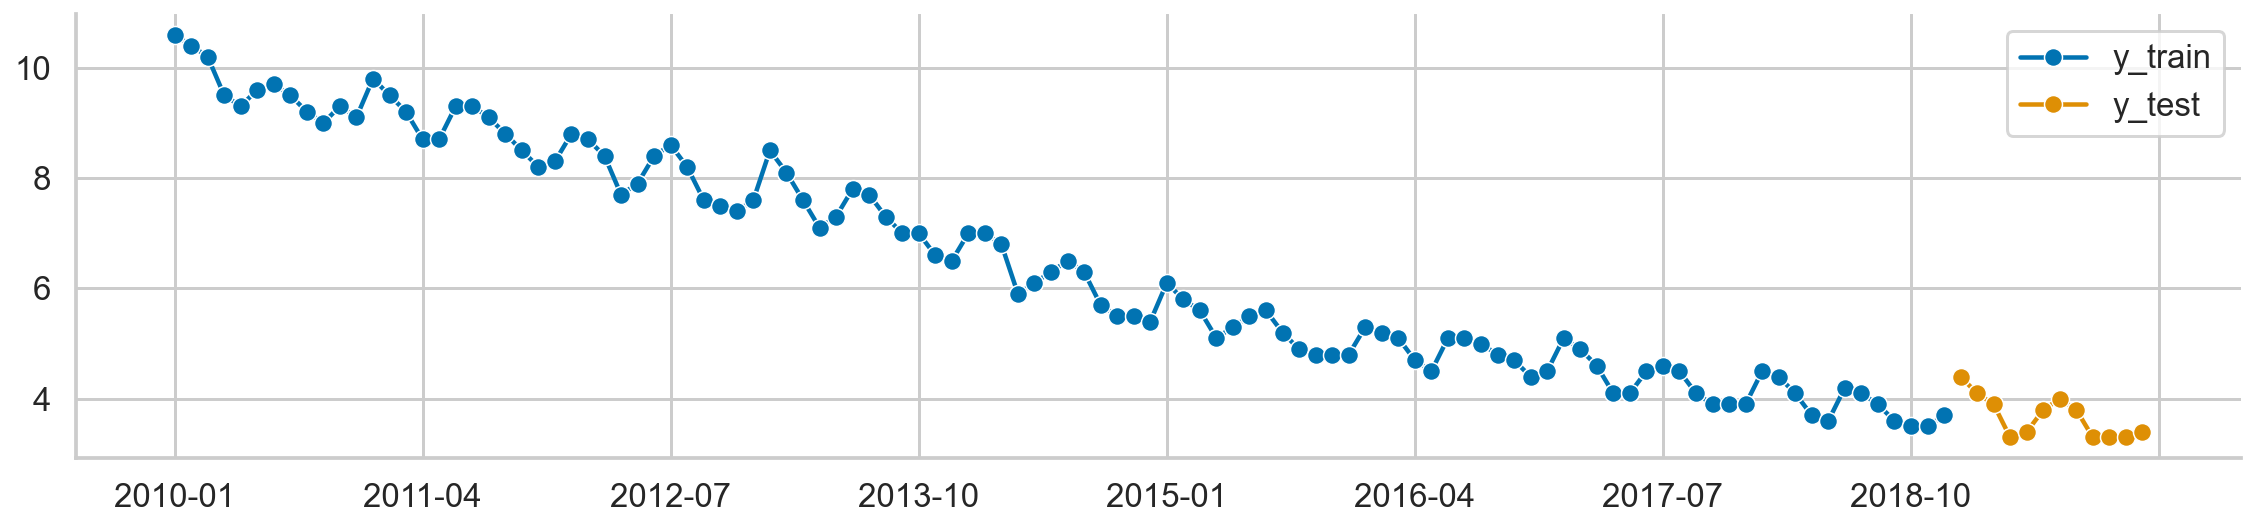

In [7]:
y_train, y_test = temporal_train_test_split(
    y, test_size=12
)
plot_series(
    y_train, y_test, 
    labels=["y_train", "y_test"]
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_22")

3. Set the forecast horizon to 12 months:

In [8]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'],
            dtype='period[M]', is_relative=False)

4. Instantiate the reduced regression model, fit it to the data and create predictions:

In [9]:
regressor = RandomForestRegressor(random_state=42)
rf_forecaster = make_reduction(
    estimator=regressor, 
    strategy="recursive", 
    window_length=12
)
rf_forecaster.fit(y_train)
y_pred_1 = rf_forecaster.predict(fh)

5. Evaluate the performance of the forecasts:

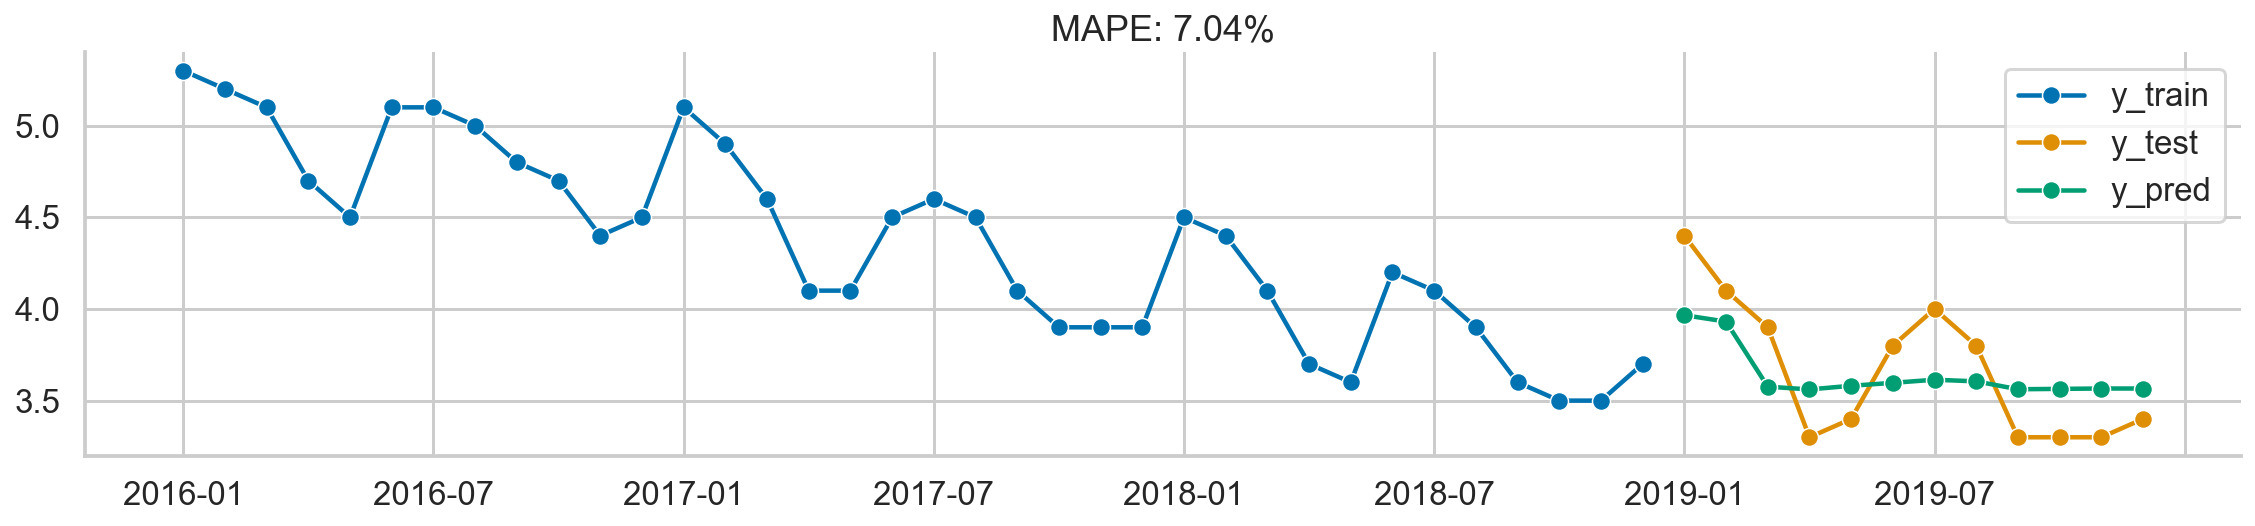

In [10]:
mape_1 = mean_absolute_percentage_error(
    y_test, y_pred_1, symmetric=False
)
fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_1,
    labels=["y_train", "y_test", "y_pred"]
)
ax.set_title(f"MAPE: {100*mape_1:.2f}%")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_23")

6. Deseasonalize the time series:

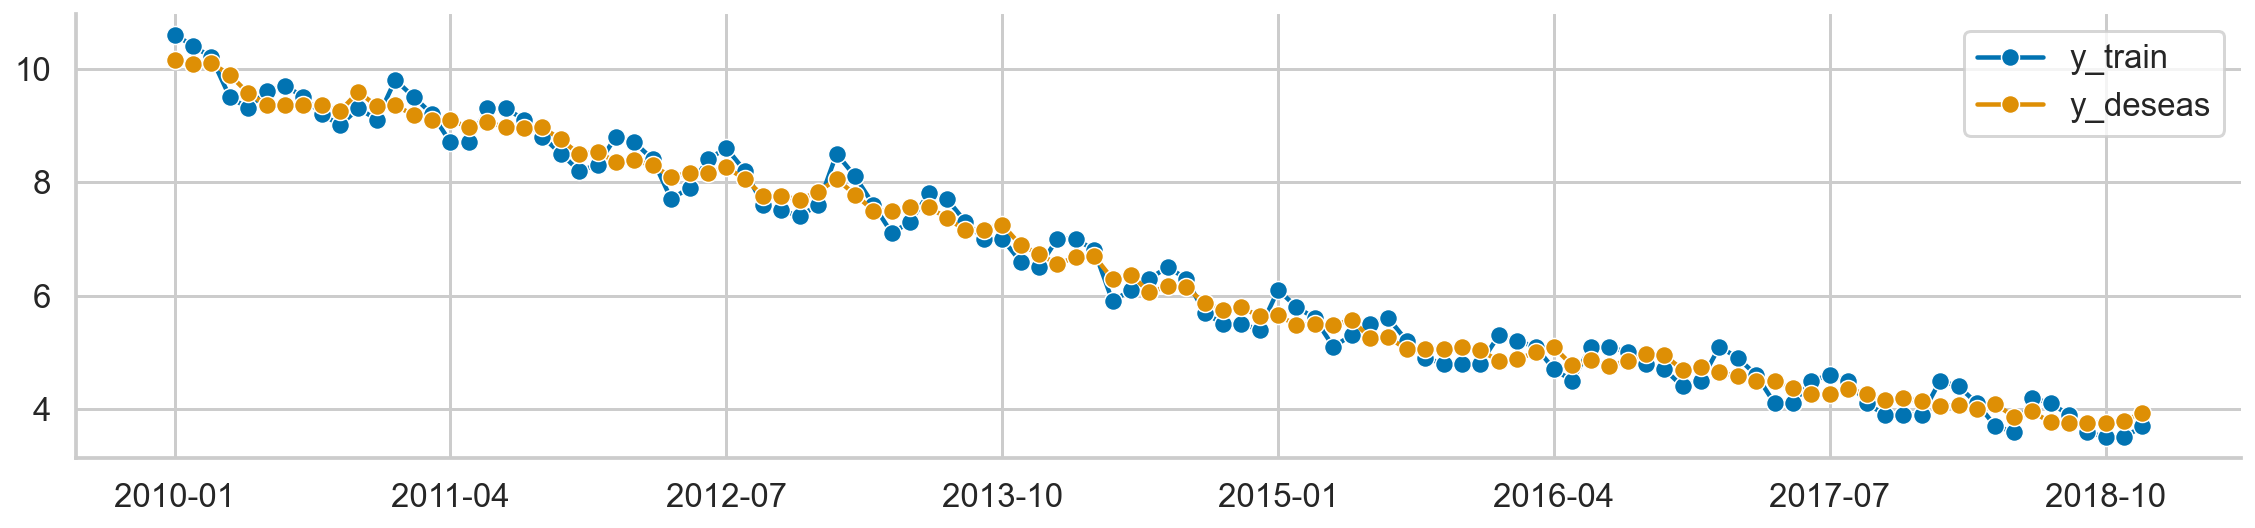

In [11]:
deseasonalizer = Deseasonalizer(model="additive", sp=12)
y_deseas = deseasonalizer.fit_transform(y_train)
plot_series(
    y_train, y_deseas, 
    labels=["y_train", "y_deseas"]
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_24")

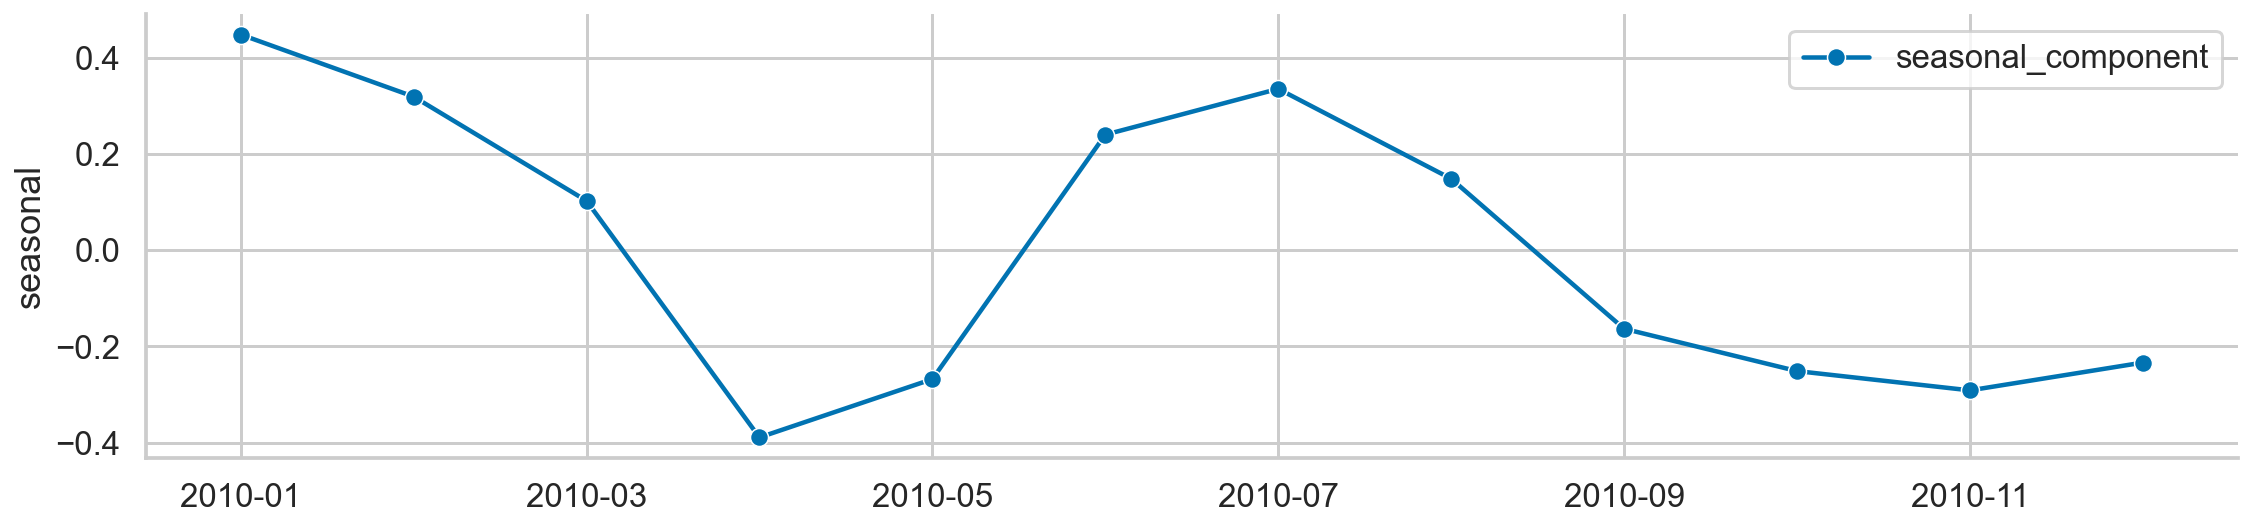

In [12]:
plot_series(
    deseasonalizer.seasonal_, 
    labels=["seasonal_component"]
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_25")

7. Detrend the time series:

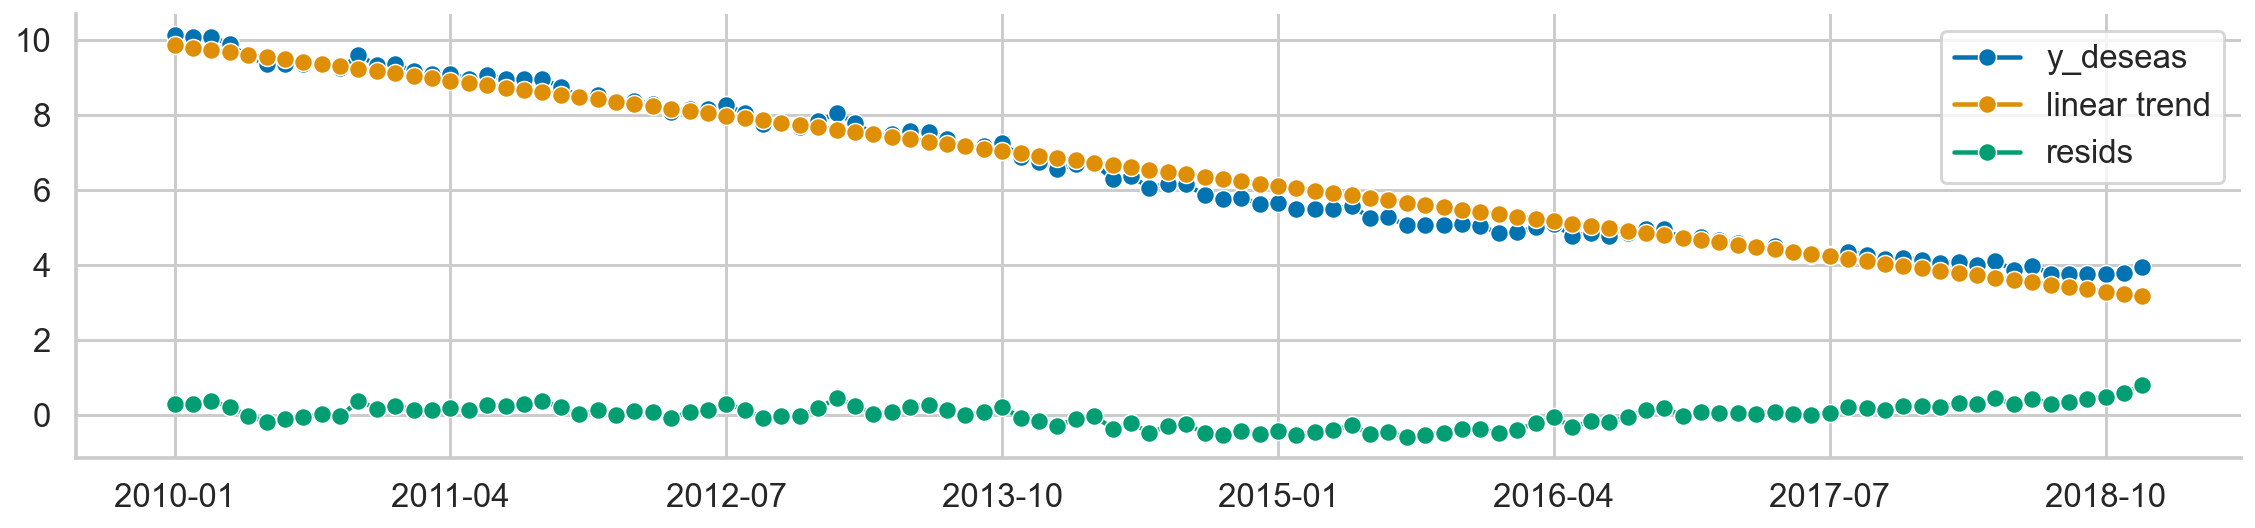

In [13]:
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_detrend = transformer.fit_transform(y_deseas)

# in-sample predictions
forecaster = PolynomialTrendForecaster(degree=1)
y_in_sample = (
    forecaster
    .fit(y_deseas)
    .predict(fh=-np.arange(len(y_deseas)))
)

plot_series(
    y_deseas, y_in_sample, y_detrend, 
    labels=["y_deseas", "linear trend", "resids"]
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_26")

8. Combine the components into a pipeline, fit it to the original time series and obtain predictions:

In [14]:
rf_pipe = TransformedTargetForecaster(
    steps = [
        ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
        ("detrend", Detrender(
            forecaster=PolynomialTrendForecaster(degree=1)
        )),
        ("forecast", rf_forecaster),
    ]
)
rf_pipe.fit(y_train)
y_pred_2 = rf_pipe.predict(fh)

9. Evaluate the pipeline's predictions:

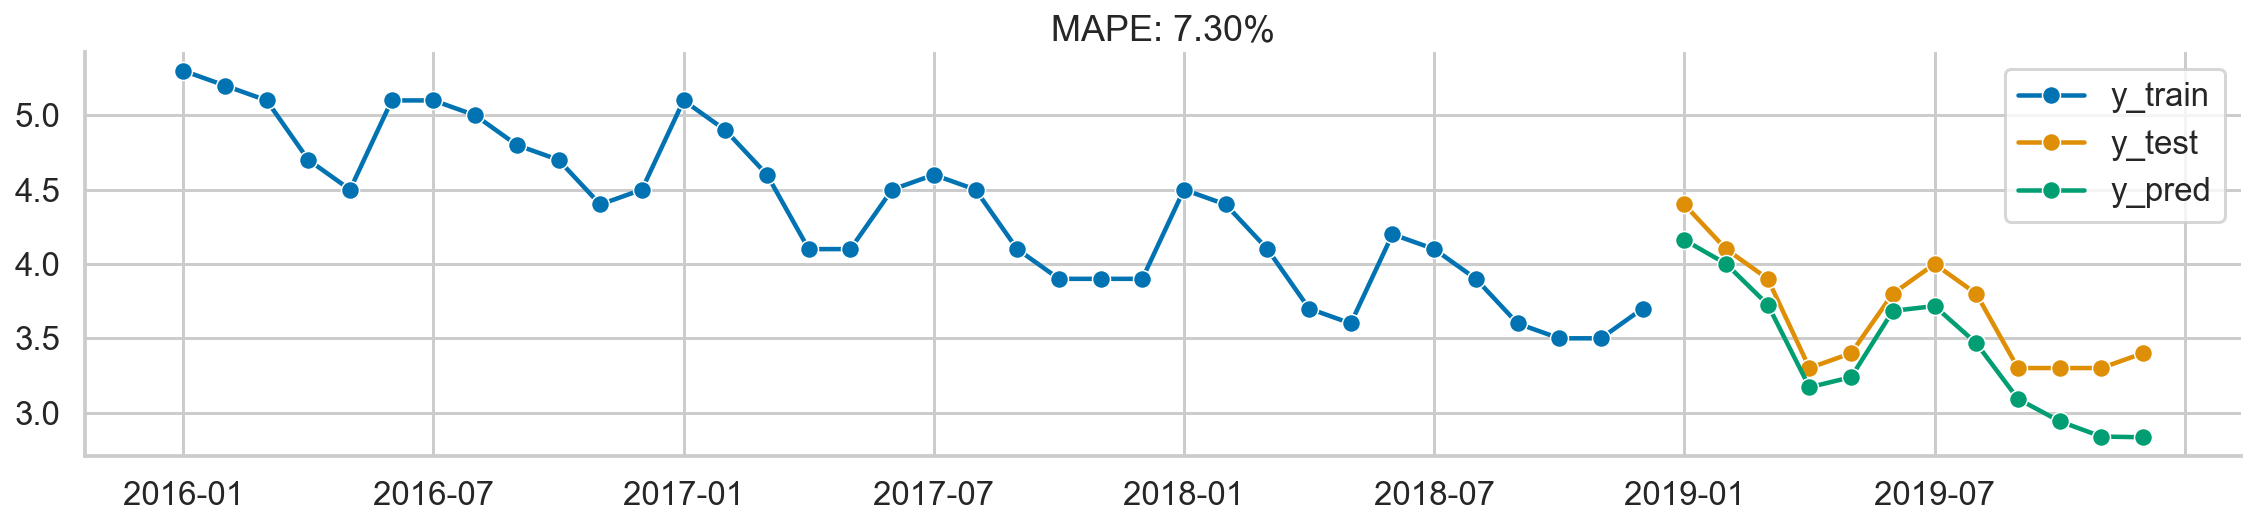

In [15]:
mape_2 = mean_absolute_percentage_error(
    y_test, y_pred_2, symmetric=False
)
fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_2,
    labels=["y_train", "y_test", "y_pred"]
)
ax.set_title(f"MAPE: {100*mape_2:.2f}%")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_27")

10. Evaluate the performance using expanding window cross-validation:

In [16]:
cv = ExpandingWindowSplitter(
    fh=list(range(1,13)), 
    initial_window=12*5, 
    step_length=12
)

cv_df = evaluate(
    forecaster=rf_pipe, 
    y=y, 
    cv=cv, 
    strategy="refit", 
    return_data=True
)

cv_df

test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                          0.017968  0.063697   0.032554                60   
1                          0.072160  0.057474   0.032321                72   
2                          0.092562  0.058789   0.032875                84   
3                          0.098999  0.062159   0.033490                96   
4                          0.072970  0.065339   0.031845               108   

    cutoff                                            y_train  \
0  2014-12           unemp_rate
2010-01        10.6
2010-0...   
1  2015-12           unemp_rate
2010-01        10.6
2010-0...   
2  2016-12           unemp_rate
2010-01        10.6
2010-0...   
3  2017-12           unemp_rate
2010-01        10.6
2010-0...   
4  2018-12           unemp_rate
2010-01        10.6
2010-0...   

                                              y_test  \
0           unemp_rate
2015-01         6.1
2015-0...   
1           unemp_rate
2016-01         5.3
2016-0...   
2           unemp_rate
2017-01         5.1
2017-0...   
3           unemp_rate
2018-01         4.5
2018-0...   
4           unemp_rate
2019-01         4.4
2019-0...   

                                              y_pred  
0           unemp_rate
2015-01    6.189424
2015-0...  
1           unemp_rate
2016-01    5.424690
2016-0...  
2           unemp_rate
2017-01    5.043032
2017-0...  
3           unemp_rate
2018-01    4.380789
2018-0...  
4           unemp_rate
2019-01    4.161463
2019-0...

In [17]:
for ind, row in cv_df.iterrows():
    print(f"Fold {ind} ----")
    print(f"Training: {row['y_train'].index.min()} - {row['y_train'].index.max()}")
    print(f"Training: {row['y_test'].index.min()} - {row['y_test'].index.max()}")


Fold 0 ----
Training: 2010-01 - 2014-12
Training: 2015-01 - 2015-12
Fold 1 ----
Training: 2010-01 - 2015-12
Training: 2016-01 - 2016-12
Fold 2 ----
Training: 2010-01 - 2016-12
Training: 2017-01 - 2017-12
Fold 3 ----
Training: 2010-01 - 2017-12
Training: 2018-01 - 2018-12
Fold 4 ----
Training: 2010-01 - 2018-12
Training: 2019-01 - 2019-12


11. Plot the predictions from the cross-validation folds:

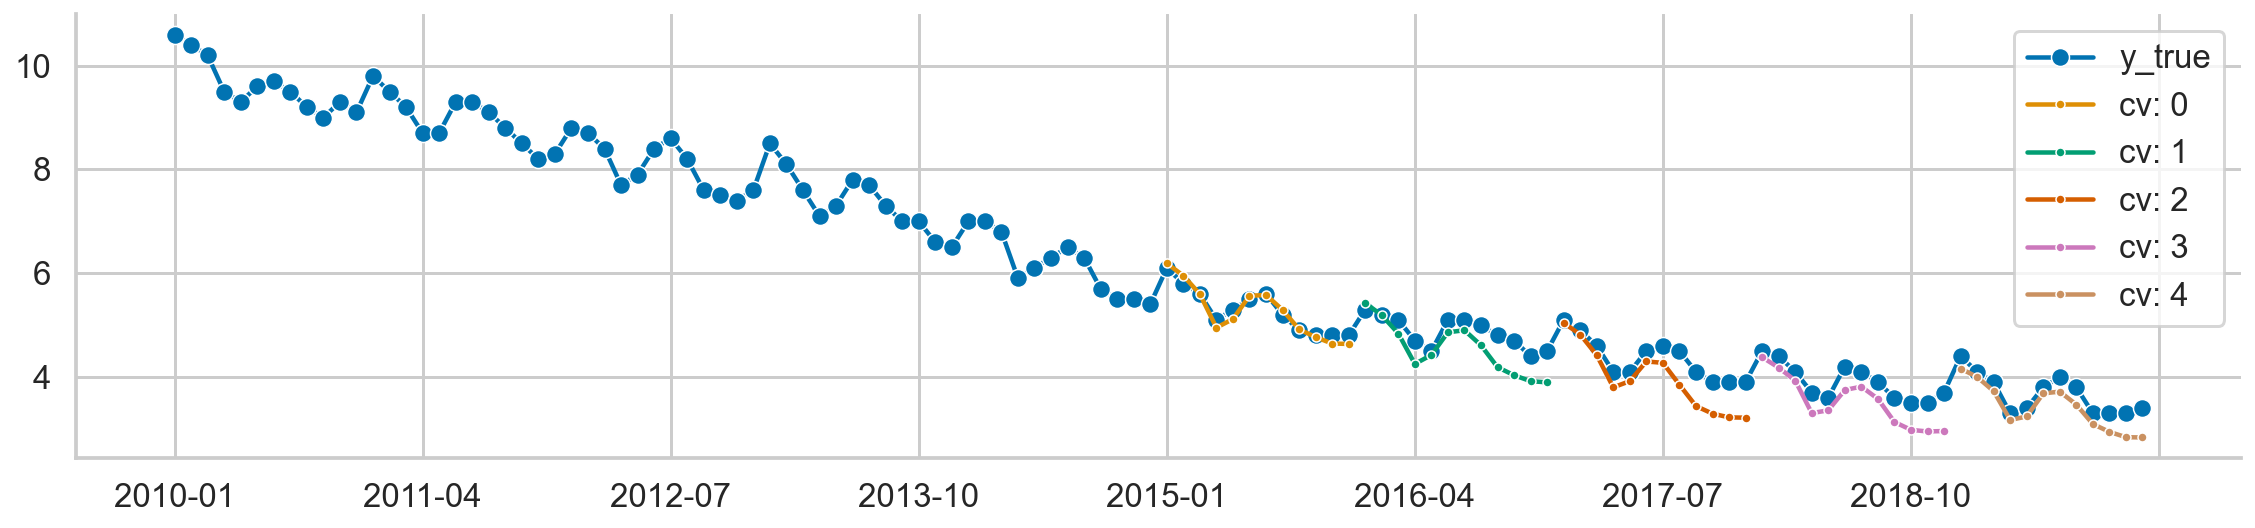

In [18]:
n_fold = len(cv_df)

plot_series(
    y, 
    *[cv_df["y_pred"].iloc[x] for x in range(n_fold)],
    markers=["o", *["."] * n_fold],
    labels=["y_true"] + [f"cv: {x}" for x in range(n_fold)]
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_29")

12. Create an ensemble forecast using the RF pipeline and AutoARIMA:

In [19]:
ensemble = EnsembleForecaster(
    forecasters = [
        ("autoarima", AutoARIMA(sp=12)),
        ("rf_pipe", rf_pipe)
    ]
)
ensemble.fit(y_train)
y_pred_3 = ensemble.predict(fh)

/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('N

13. Evaluate the ensemble's predictions:

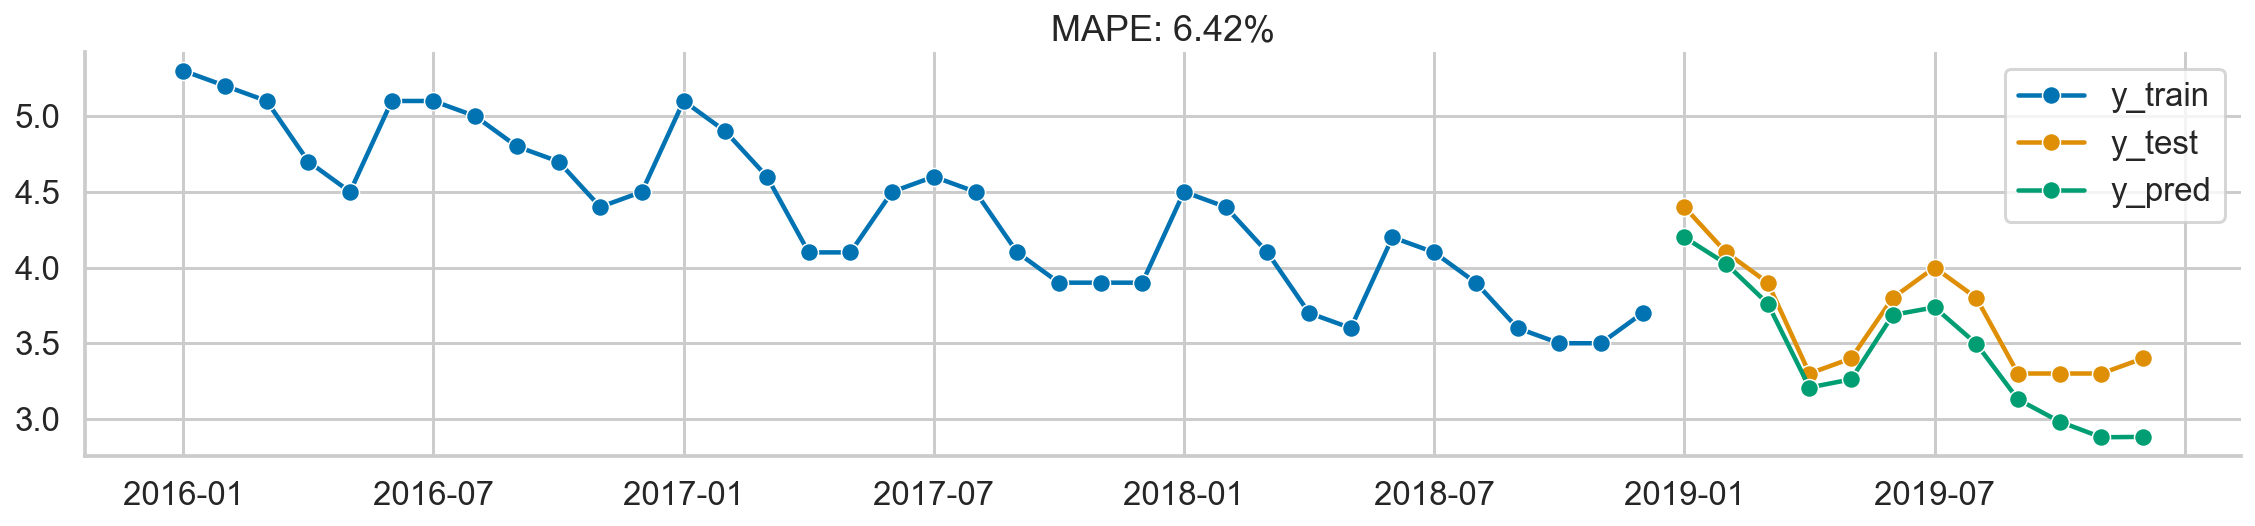

In [20]:
mape_3 = mean_absolute_percentage_error(
    y_test, y_pred_3, symmetric=False
)
fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_3,
    labels=["y_train", "y_test", "y_pred"]
)
ax.set_title(f"MAPE: {100*mape_3:.2f}%")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_30")

### There's more

1. Create naive forecasts using the `NaiveForecaster`:

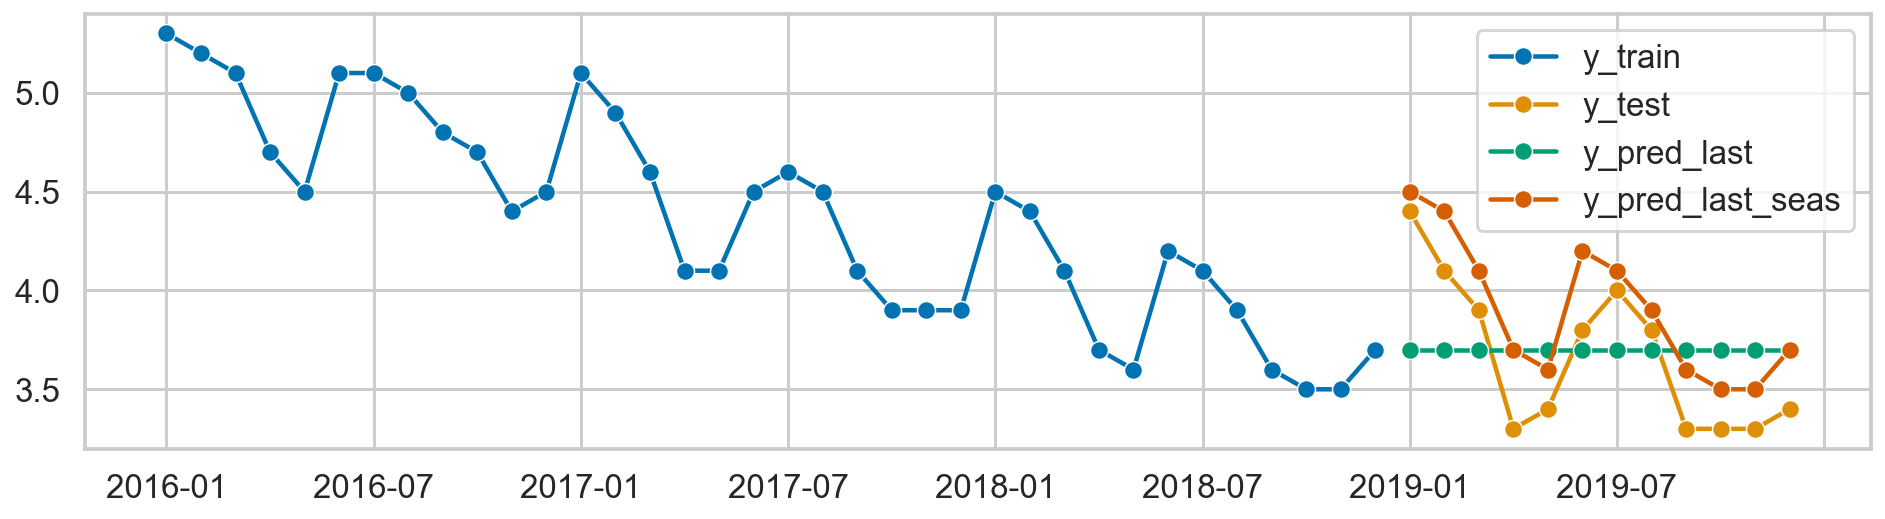

In [21]:
from sktime.forecasting.naive import NaiveForecaster

fh = ForecastingHorizon(y_test.index, is_relative=False)

naive_fcst_last = NaiveForecaster(strategy="last")
naive_fcst_last.fit(y_train)
y_last = naive_fcst_last.predict(fh)

naive_fcst_seas = NaiveForecaster(strategy="last", sp=12)
naive_fcst_seas.fit(y_train)
y_seasonal_last = naive_fcst_seas.predict(fh)

plot_series(
    y_train["2016":], y_test, y_last, y_seasonal_last, 
    labels=["y_train", "y_test", "y_pred_last", "y_pred_last_seas"]
);

2. Inspect all the available models:

In [22]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True)

/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/sktime/utils/validation/_dependencies.py:117: UserWarning: str requires package 'dtw-python' to be present in the python environment, but 'dtw-python' was not found. 'dtw-python' is a soft dependency and not included in the base sktime installation. Please run: `pip install dtw-python` to install the dtw-python package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/sktime/utils/validation/_dependencies.py:117: UserWarning: No module named 'hmmlearn'. 'hmmlearn.hmm' is a soft dependency and not included in the base sktime installation. Please run: `pip install hmmlearn.hmm` to install the hmmlearn.hmm package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/sktime/utils/va

name  \
0                                        ARDL   
1                                       ARIMA   
2                                   AutoARIMA   
3                                     AutoETS   
4                      AutoEnsembleForecaster   
5                                        BATS   
6                           BaggingForecaster   
7                    ColumnEnsembleForecaster   
8                          ConformalIntervals   
9                                     Croston   
10          DirRecTabularRegressionForecaster   
11       DirRecTimeSeriesRegressionForecaster   
12          DirectTabularRegressionForecaster   
13       DirectTimeSeriesRegressionForecaster   
14                                 DontUpdate   
15                              DynamicFactor   
16                         EnsembleForecaster   
17                       ExponentialSmoothing   
18                                  ForecastX   
19                    ForecastingGridSearchCV   
20                        ForecastingPipeline   
21              ForecastingRandomizedSearchCV   
22     MultioutputTabularRegressionForecaster   
23  MultioutputTimeSeriesRegressionForecaster   
24                        MultiplexForecaster   
25                            NaiveForecaster   
26                              NaiveVariance   
27                   OnlineEnsembleForecaster   
28                     PluginParamsForecaster   
29                  PolynomialTrendForecaster   
30                                    Prophet   
31                       ReconcilerForecaster   
32       RecursiveTabularRegressionForecaster   
33    RecursiveTimeSeriesRegressionForecaster   
34                                    SARIMAX   
35                              STLForecaster   
36                         StackingForecaster   
37                     StatsForecastAutoARIMA   
38                                      TBATS   
39                            ThetaForecaster   
40                TransformedTargetForecaster   
41                            TrendForecaster   
42                       UnobservedComponents   
43                                UpdateEvery   
44                          UpdateRefitsEvery   
45                                        VAR   
46                                     VARMAX   
47                                       VECM   

                                            estimator  
0              <class 'sktime.forecasting.ardl.ARDL'>  
1            <class 'sktime.forecasting.arima.ARIMA'>  
2        <class 'sktime.forecasting.arima.AutoARIMA'>  
3            <class 'sktime.forecasting.ets.AutoETS'>  
4   <class 'sktime.forecasting.compose._ensemble.A...  
5              <class 'sktime.forecasting.bats.BATS'>  
6   <class 'sktime.forecasting.compose._bagging.Ba...  
7   <class 'sktime.forecasting.compose._column_ens...  
8   <class 'sktime.forecasting.conformal.Conformal...  
9        <class 'sktime.forecasting.croston.Croston'>  
10  <class 'sktime.forecasting.compose._reduce.Dir...  
11  <class 'sktime.forecasting.compose._reduce.Dir...  
12  <class 'sktime.forecasting.compose._reduce.Dir...  
13  <class 'sktime.forecasting.compose._reduce.Dir...  
14  <class 'sktime.forecasting.stream._update.Dont...  
15  <class 'sktime.forecasting.dynamic_factor.Dyna...  
16  <class 'sktime.forecasting.compose._ensemble.E...  
17  <class 'sktime.forecasting.exp_smoothing.Expon...  
18  <class 'sktime.forecasting.compose._pipeline.F...  
19  <class 'sktime.forecasting.model_selection._tu...  
20  <class 'sktime.forecasting.compose._pipeline.F...  
21  <class 'sktime.forecasting.model_selection._tu...  
22  <class 'sktime.forecasting.compose._reduce.Mul...  
23  <class 'sktime.forecasting.compose._reduce.Mul...  
24  <class 'sktime.forecasting.compose._multiplexe...  
25  <class 'sktime.forecasting.naive.NaiveForecast...  
26   <class 'sktime.forecasting.naive.NaiveVariance'>  
27  <class 'sktime.forecasting.online_learning._on...  
28  <class 'skt

## 7.4 Forecasting with Meta's Prophet

### How to do it...

1. Import the libraries and authenticate with Nasdaq Data Link:

In [3]:
import pandas as pd
import nasdaqdatalink
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the daily gold prices:

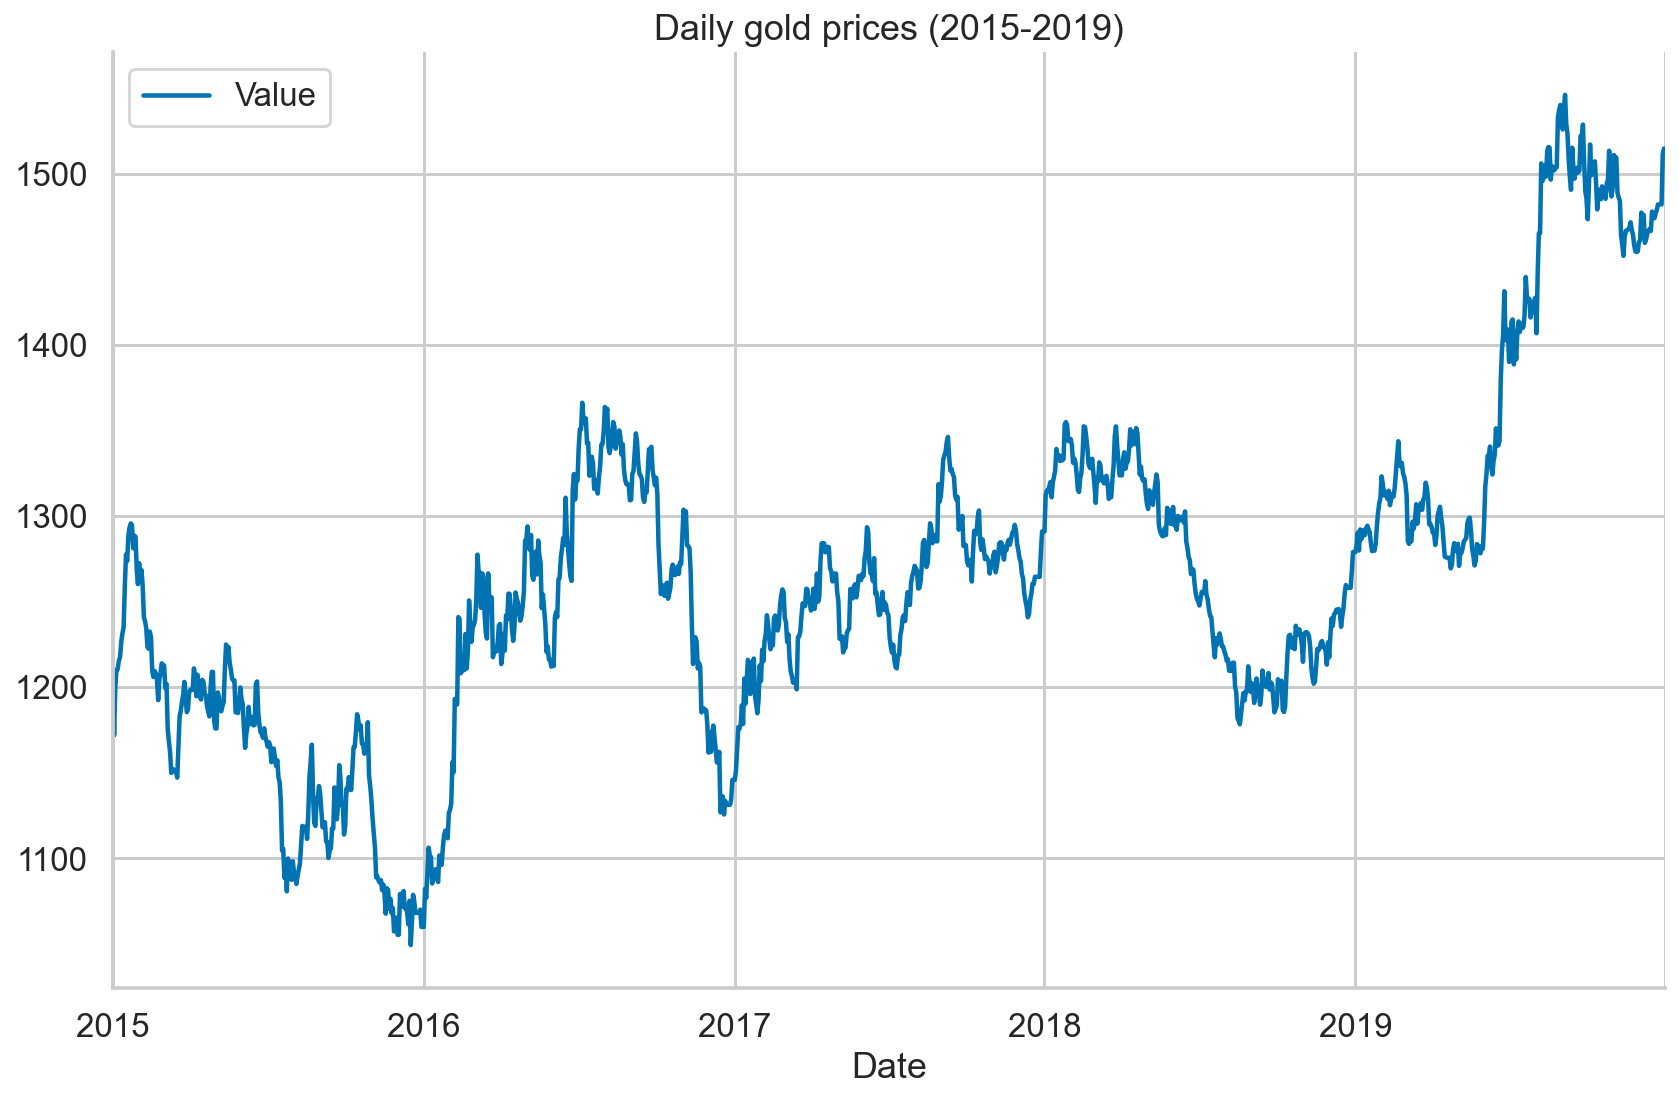

In [4]:
df = nasdaqdatalink.get(
    dataset="WGC/GOLD_DAILY_USD",
    start_date="2015-01-01",
    end_date="2019-12-31"
)

df.plot(title="Daily gold prices (2015-2019)")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_31")

3. Rename the columns:

In [5]:
df = df.reset_index(drop=False)
df.columns = ["ds", "y"]

4. Split the series into the training and test sets:

In [6]:
train_indices = df["ds"] < "2019-10-01"
df_train = df.loc[train_indices].dropna()
df_test = (
    df
    .loc[~train_indices]
    .reset_index(drop=True)
)

5. Create the instance of the model and fit it to the data:

In [7]:
prophet = Prophet(changepoint_range=0.9)
prophet.add_country_holidays(country_name="US")
prophet.add_seasonality(
    name="monthly", period=30.5, fourier_order=5
)
prophet.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6. Forecast the gold prices for the fourth quarter of 2019 and plot the results:

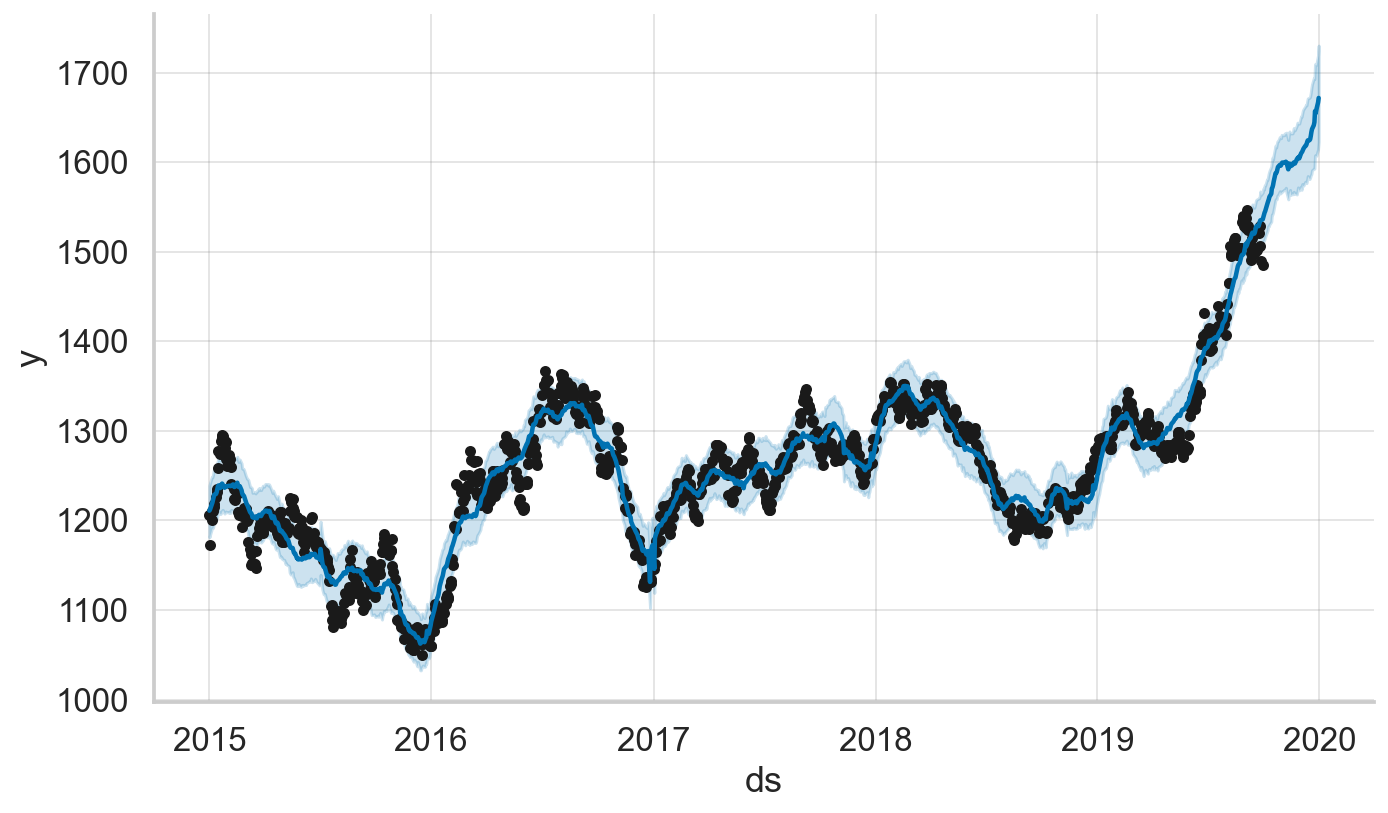

In [8]:
df_future = prophet.make_future_dataframe(
    periods=len(df_test), freq="B"
)
df_pred = prophet.predict(df_future)
prophet.plot(df_pred)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_32")

In [9]:
df_pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

7. Add changepoints to the plot:

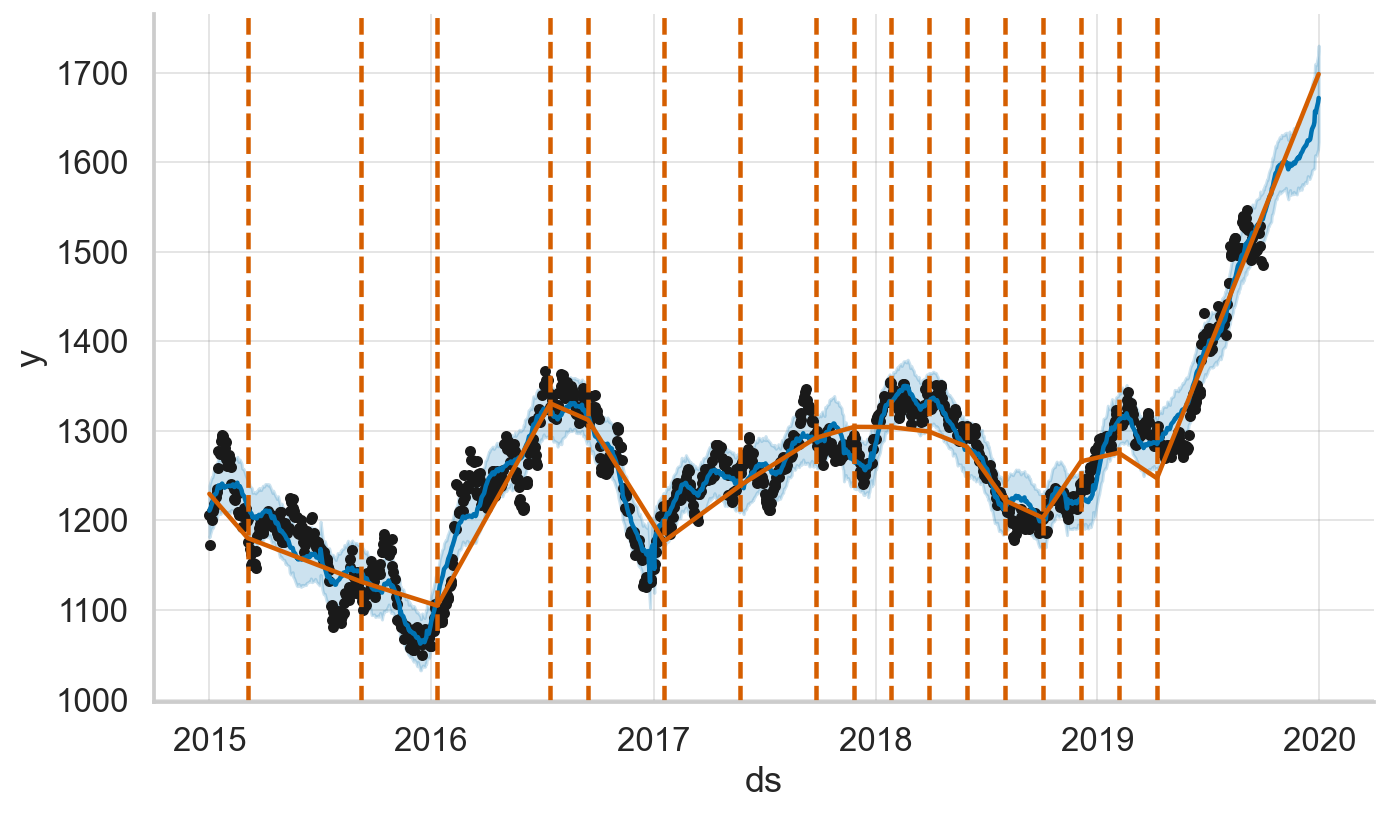

In [10]:
fig = prophet.plot(df_pred)
a = add_changepoints_to_plot(
    fig.gca(), prophet, df_pred
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_33")

In [11]:
prophet.changepoints

45     2015-03-05
89     2015-05-06
134    2015-07-08
178    2015-09-08
223    2015-11-10
267    2016-01-11
312    2016-03-14
356    2016-05-13
401    2016-07-15
445    2016-09-15
490    2016-11-17
534    2017-01-18
579    2017-03-22
623    2017-05-23
668    2017-07-25
712    2017-09-25
757    2017-11-27
801    2018-01-26
846    2018-03-30
890    2018-05-31
935    2018-08-02
979    2018-10-03
1024   2018-12-05
1068   2019-02-05
1113   2019-04-09
Name: ds, dtype: datetime64[ns]

8. Inspect the decomposition of the time series:

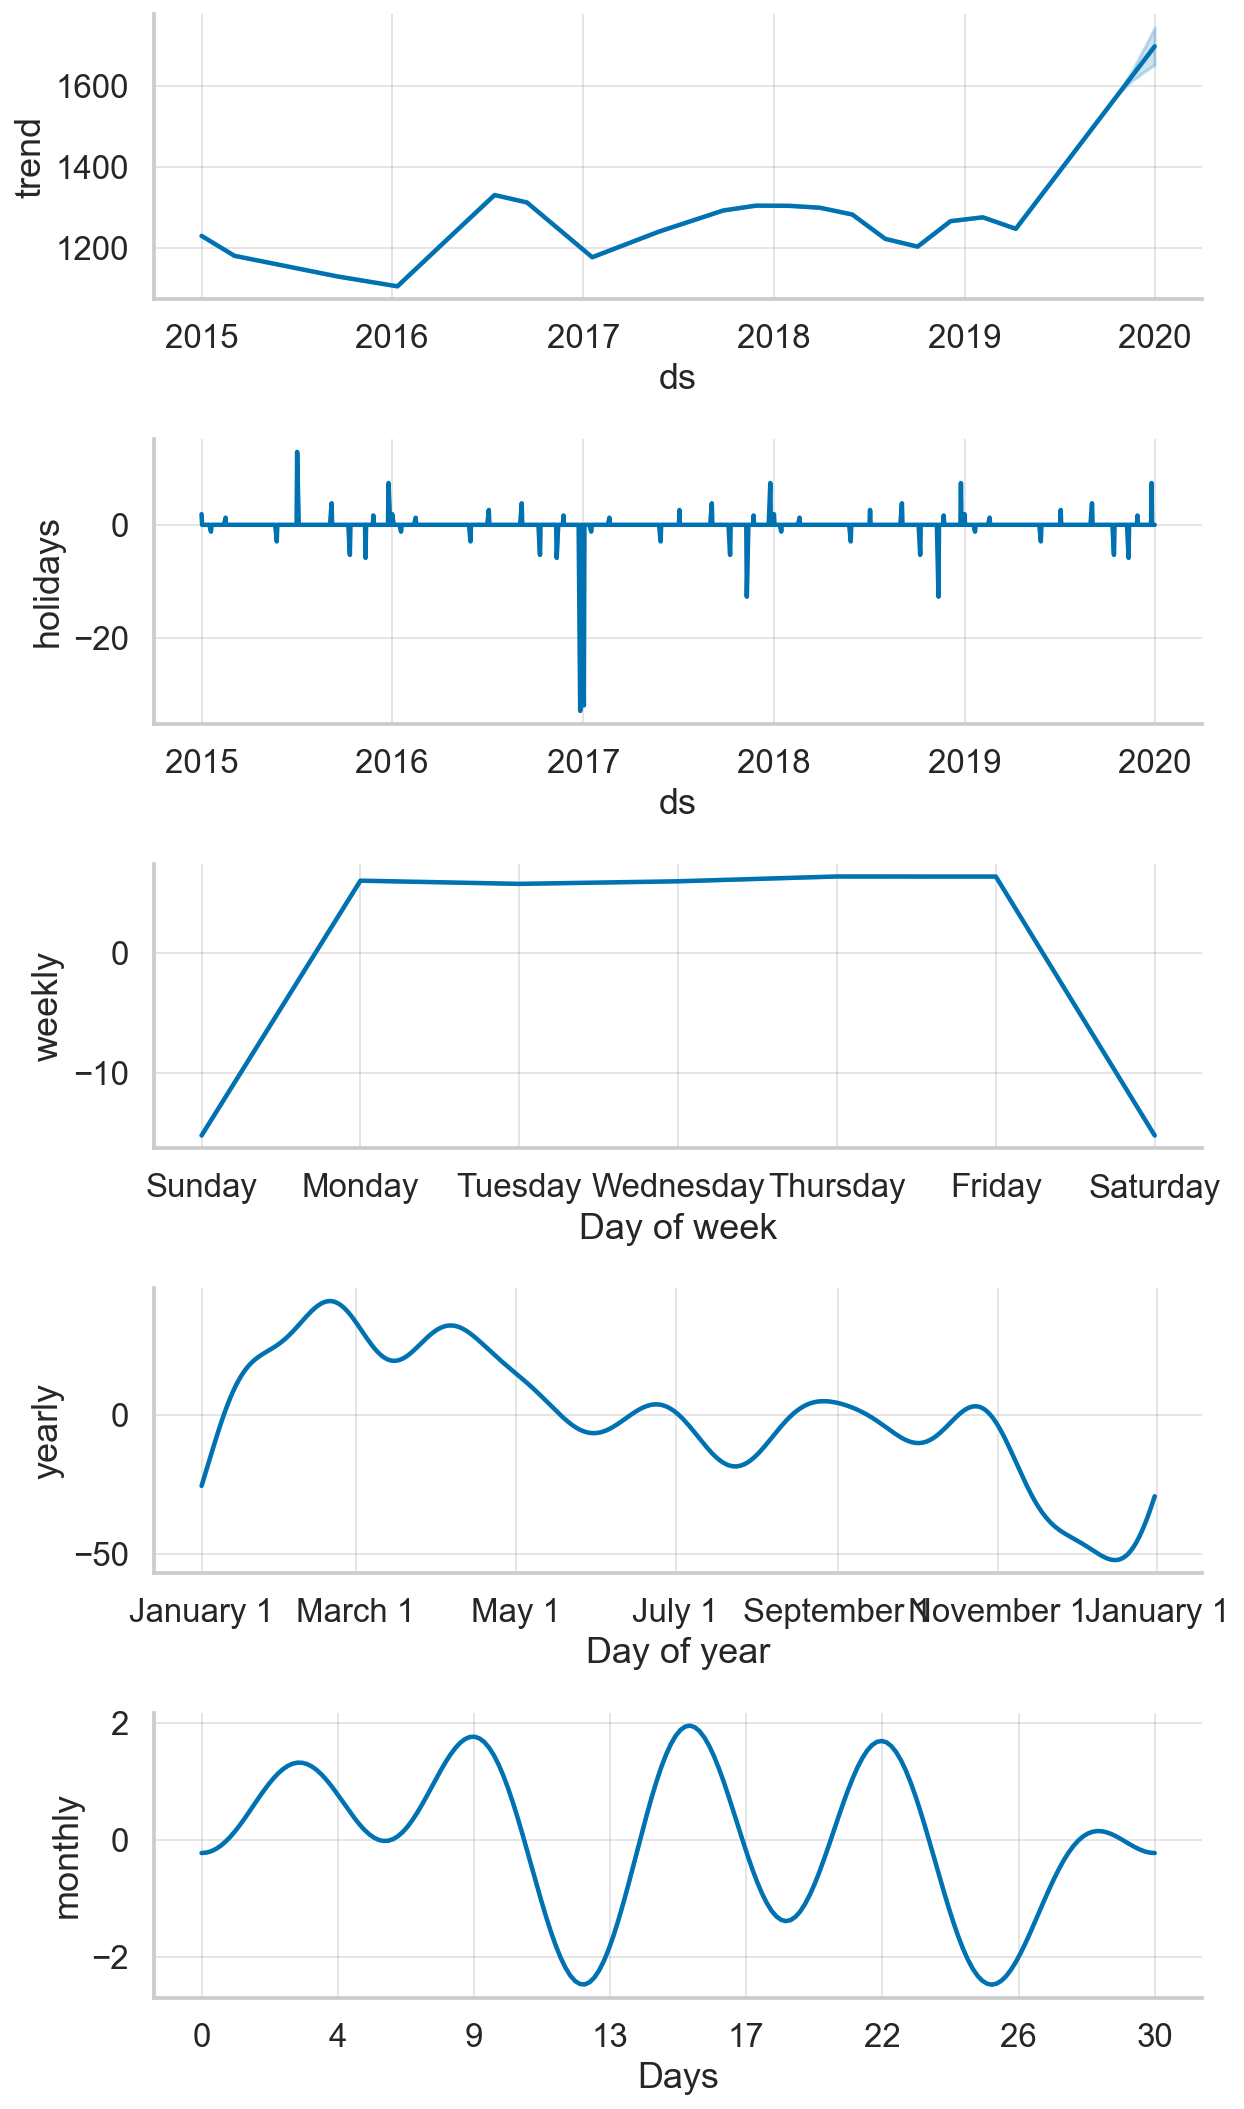

In [12]:
prophet.plot_components(df_pred)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_34")

9. Merge the test set with the forecasts:

In [13]:
SELECTED_COLS = [
    "ds", "yhat", "yhat_lower", "yhat_upper"
]

df_pred = (
    df_pred
    .loc[:, SELECTED_COLS]
    .reset_index(drop=True)
)
df_test = df_test.merge(df_pred, on=["ds"], how="left")
df_test["ds"] = pd.to_datetime(df_test["ds"])
df_test = df_test.set_index("ds")

10. Plot the test values vs. predictions:

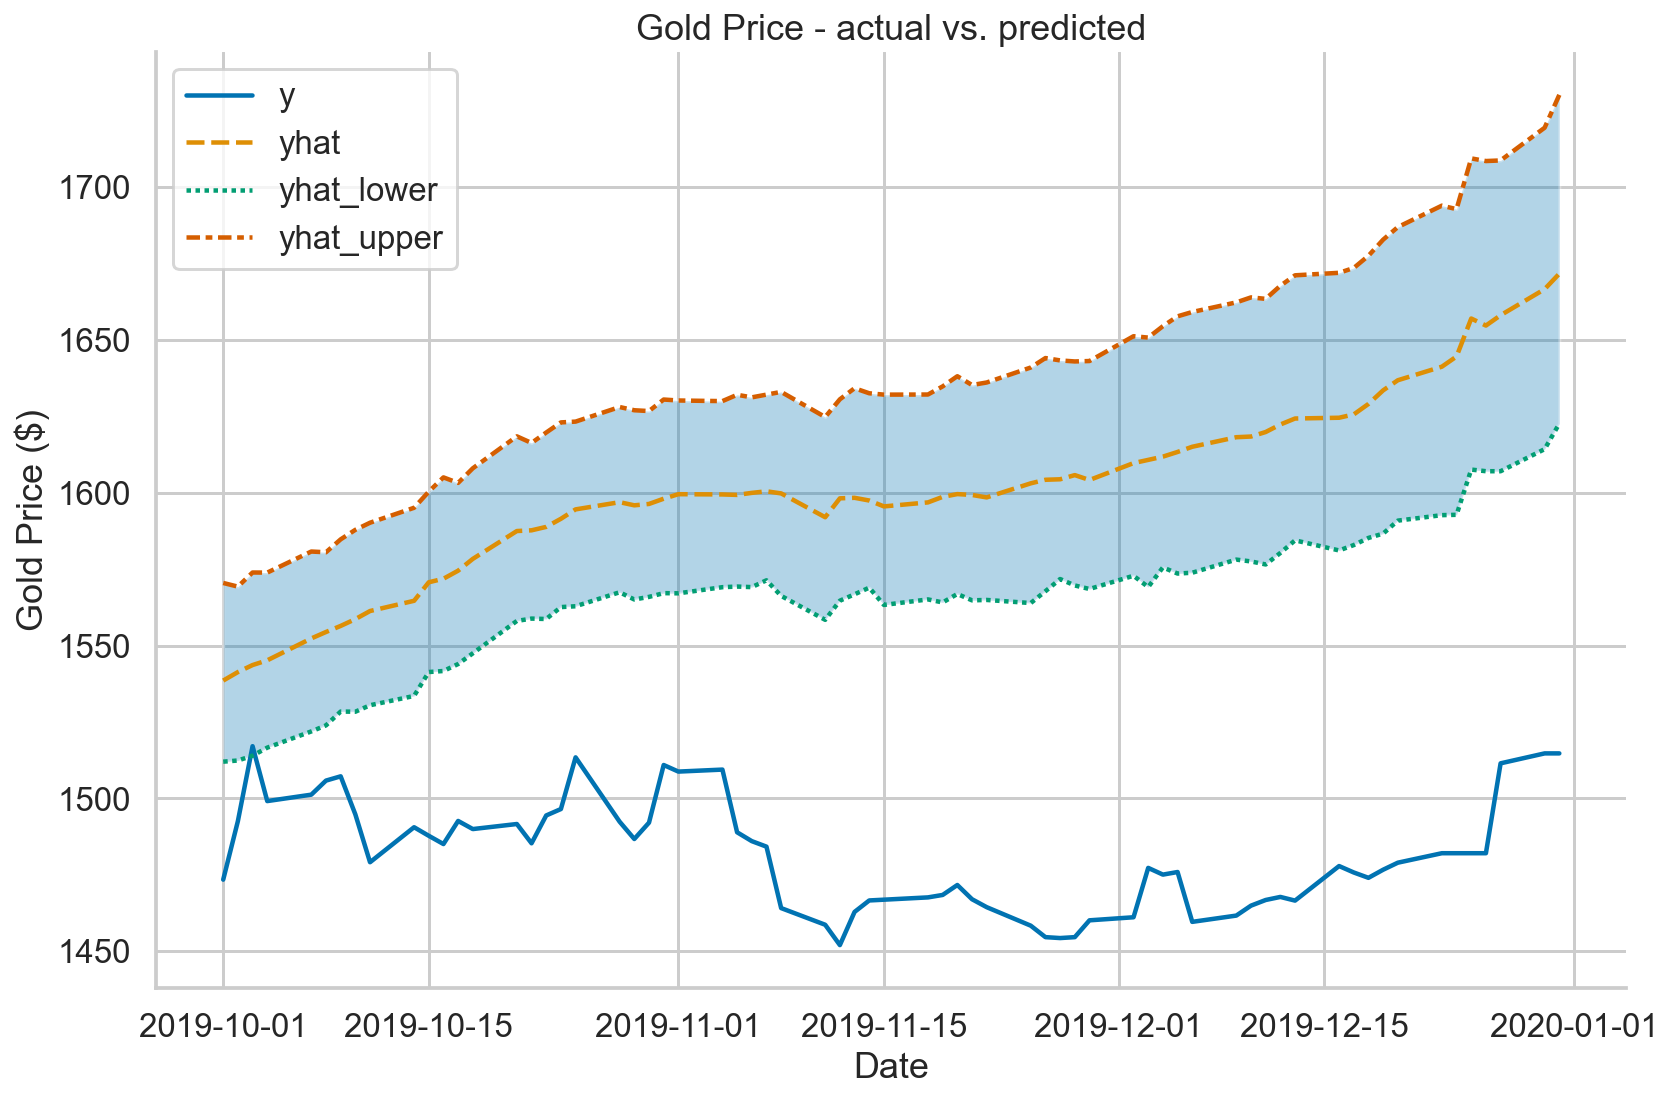

In [14]:
fig, ax = plt.subplots(1, 1)

PLOT_COLS = [
    "y", "yhat", "yhat_lower", "yhat_upper"
]
ax = sns.lineplot(data=df_test[PLOT_COLS])
ax.fill_between(
    df_test.index,
    df_test["yhat_lower"],
    df_test["yhat_upper"],
    alpha=0.3
)

ax.set(
    title="Gold Price - actual vs. predicted",
    xlabel="Date",
    ylabel="Gold Price ($)"
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_35")

### There's more

1. Import the libraries:

In [1]:
from prophet.diagnostics import (cross_validation, 
                                 performance_metrics)
from prophet.plot import plot_cross_validation_metric

2. Run Prophet's cross-validation :

In [23]:
df_cv = cross_validation(
    prophet, 
    initial="756 days", 
    period="60 days", 
    horizon = "60 days"
)

df_cv

INFO:prophet:Making 16 forecasts with cutoffs between 2017-02-12 00:00:00 and 2019-08-01 00:00:00
100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


ds         yhat   yhat_lower   yhat_upper        y     cutoff
0   2017-02-13  1240.428658  1213.811716  1265.413773  1222.25 2017-02-12
1   2017-02-14  1244.035274  1221.035701  1268.480139  1230.75 2017-02-12
2   2017-02-15  1245.784079  1217.371162  1271.120010  1224.40 2017-02-12
3   2017-02-16  1247.101206  1220.042671  1274.265338  1240.55 2017-02-12
4   2017-02-17  1247.049617  1220.807794  1275.228078  1241.95 2017-02-12
..         ...          ...          ...          ...      ...        ...
681 2019-09-24  1411.521433  1375.322514  1448.461713  1520.65 2019-08-01
682 2019-09-25  1411.647219  1373.687950  1451.544195  1528.75 2019-08-01
683 2019-09-26  1411.175984  1376.421207  1446.685374  1506.40 2019-08-01
684 2019-09-27  1409.462673  1371.380939  1446.990465  1489.90 2019-08-01
685 2019-09-30  1408.982620  1372.644691  1450.695071  1485.30 2019-08-01

[686 rows x 6 columns]

In [24]:
df_cv["cutoff"].value_counts().sort_index()

2017-02-12    44
2017-04-13    42
2017-06-12    44
2017-08-11    42
2017-10-10    43
2017-12-09    43
2018-02-07    42
2018-04-08    44
2018-06-07    42
2018-08-06    44
2018-10-05    42
2018-12-04    43
2019-02-02    43
2019-04-03    42
2019-06-02    44
2019-08-01    42
Name: cutoff, dtype: int64

In [25]:
df_cv.head(50)

ds         yhat   yhat_lower   yhat_upper        y     cutoff
0  2017-02-13  1240.428658  1213.811716  1265.413773  1222.25 2017-02-12
1  2017-02-14  1244.035274  1221.035701  1268.480139  1230.75 2017-02-12
2  2017-02-15  1245.784079  1217.371162  1271.120010  1224.40 2017-02-12
3  2017-02-16  1247.101206  1220.042671  1274.265338  1240.55 2017-02-12
4  2017-02-17  1247.049617  1220.807794  1275.228078  1241.95 2017-02-12
5  2017-02-20  1250.048517  1224.113500  1276.153809  1237.30 2017-02-12
6  2017-02-21  1252.469021  1226.322036  1279.043445  1233.20 2017-02-12
7  2017-02-22  1251.754518  1224.803601  1277.854792  1236.65 2017-02-12
8  2017-02-23  1251.401397  1226.416148  1277.396326  1247.90 2017-02-12
9  2017-02-24  1250.506569  1222.824175  1276.222176  1253.65 2017-02-12
10 2017-02-27  1250.268990  1223.762323  1277.278796  1257.20 2017-02-12
11 2017-02-28  1249.532238  1220.624918  1275.954834  1255.60 2017-02-12
12 2017-03-01  1247.969994  1219.177930  1275.045543  1240.40 2017-02-12
13 2017-03-02  1247.881398  1220.913445  1274.535965  1238.10 2017-02-12
14 2017-03-03  1247.408869  1220.432957  1273.425373  1226.50 2017-02-12
15 2017-03-06  1243.064864  1215.520956  1269.272217  1230.95 2017-02-12
16 2017-03-07  1241.313438  1214.022285  1268.355048  1216.65 2017-02-12
17 2017-03-08  1240.135210  1211.917868  1266.993950  1209.20 2017-02-12
18 2017-03-09  1241.176361  1213.341451  1267.556637  1206.55 2017-02-12
19 2017-03-10  1241.410201  1213.543131  1267.873270  1202.65 2017-02-12
20 2017-03-13  1234.739654  1207.760674  1262.850705  1204.20 2017-02-12
21 2017-03-14  1232.990092  1207.518018  1261.279268  1204.60 2017-02-12
22 2017-03-15  1232.517235  1206.251108  1261.889038  1198.80 2017-02-12
23 2017-03-16  1234.345022  1205.153505  1263.983761  1229.35 2017-02-12
24 2017-03-17  1235.111539  1207.885912  1262.947575  1229.60 2017-02-12
25 2017-03-20  1232.273277  1202.477328  1262.317679  1232.40 2017-02-12
26 2017-03-21  1232.638752  1202.867620  1260.580128  1241.60 2017-02-12
27 2017-03-22  1233.500572  1205.915653  1264.279299  1249.05 2017-02-12
28 2017-03-23  1235.552072  1204.989190  1266.575848  1247.50 2017-02-12
29 2017-03-24  1236.009371  1206.198350  1267.423160  1247.50 2017-02-12
30 2017-03-27  1235.805441  1206.021820  1265.580423  1257.55 2017-02-12
31 2017-03-28  1237.142186  1204.747032  1266.452421  1257.25 2017-02-12
32 2017-03-29  1238.017968  1204.542393  1268.961348  1251.10 2017-02-12
33 2017-03-30  1239.618355  1207.434116  1269.343904  1248.80 2017-02-12
34 2017-03-31  1240.147631  1209.362449  1272.613776  1244.85 2017-02-12
35 2017-04-03  1243.528759  1213.088426  1278.052063  1247.25 2017-02-12
36 2017-04-04  1244.330214  1213.821816  1279.265035  1257.65 2017-02-12
37 2017-04-05  1243.602359  1211.055650  1276.602006  1245.80 2017-02-12
38 2017-04-06  1243.716238  1210.512320  1274.195157  1252.50 2017-02-12
39 2017-04-07  1243.839435  1209.642861  1278.086235  1266.45 2017-02-12
40 2017-04-10  1247.915714  1214.905303  1281.154909  1250.05 2017-02-12
41 2017-04-11  1247.116655  1211.902135  1281.905821  1252.90 2017-02-12
42 2017-04-12  1244.432194  1209.025652  1279.274792  1274.30 2017-02-12
43 2017-04-13  1243.161657  1206.891107  1278.732317  1284.15 2017-02-12
44 2017-04-14  1254.751500  1229.945350  1281.455800  1284.15 2017-04-13
45 2017-04-17  1260.084138  1234.028596  1285.447502  1284.15 2017-04-13
46 2017-04-18  1260.104933  1232.273162  1284.435967  1278.95 2017-04-13
47 2017-04-19  1258.560408  1232.866412  1284.917408  1279.05 2017-04-13
48 2017-04-20  1259.510927  1233.969649  1284.677110  1282.10 2017-04-13
49 2017-04-21  1260.397100  1235.248169  1287.961689  1281.85 2017-04-13

3. Calculate the aggregated performance metrics:

In [26]:
df_p = performance_metrics(df_cv)
df_p

horizon          mse       rmse        mae      mape     mdape     smape  \
0   6 days  1748.610554  41.816391  31.559107  0.024066  0.018103  0.024227   
1   7 days  1989.890473  44.608188  33.977247  0.025884  0.020106  0.026108   
2   8 days  2202.222234  46.927841  35.882566  0.027195  0.022757  0.027480   
3   9 days  2367.956551  48.661654  38.572966  0.029299  0.024370  0.029526   
4  10 days  2529.118619  50.290343  41.208362  0.031576  0.031014  0.031808   
5  11 days  2691.744910  51.882029  42.421694  0.032552  0.031014  0.032844   
6  12 days  2725.613313  52.207407  43.137264  0.033074  0.030830  0.033348   
7  13 days  2937.700093  54.200554  44.898209  0.034387  0.032834  0.034652   
8  14 days  3270.445886  57.187812  47.956755  0.036807  0.034913  0.037067   
9  15 days  3656.224802  60.466725  50.168416  0.038266  0.035763  0.038576   
10 16 days  3837.925393  61.950992  51.570920  0.039256  0.033129  0.039491   
11 17 days  3859.947438  62.128475  52.908730  0.040497  0.036749  0.040735   
12 18 days  3936.315802  62.740065  53.693452  0.041142  0.035686  0.041452   
13 19 days  4080.950745  63.882320  54.905110  0.041970  0.036749  0.042306   
14 20 days  4223.020396  64.984770  56.567275  0.043225  0.036941  0.043578   
15 21 days  4480.527772  66.936745  59.575345  0.045700  0.038855  0.046045   
16 22 days  4955.999595  70.398861  62.749513  0.047965  0.043397  0.048336   
17 23 days  5413.814826  73.578630  65.455427  0.049863  0.046530  0.050201   
18 24 days  5773.548621  75.983871  68.419835  0.052292  0.049456  0.052686   
19 25 days  5857.291510  76.532944  69.197925  0.053004  0.047429  0.053439   
20 26 days  6160.637816  78.489731  70.683553  0.053951  0.050115  0.054429   
21 27 days  6396.865837  79.980409  71.819000  0.054624  0.054862  0.055206   
22 28 days  6600.299699  81.242229  73.293440  0.055775  0.055808  0.056465   
23 29 days  6631.747643  81.435543  73.537074  0.055898  0.056298  0.056558   
24 30 days  6565.291132  81.026484  72.651896  0.055209  0.056451  0.055679   
25 31 days  6682.325247  81.745491  72.371687  0.055106  0.056451  0.055624   
26 32 days  6506.742509  80.664382  70.061230  0.053383  0.056192  0.053971   
27 33 days  6510.631549  80.688485  69.237549  0.052690  0.055909  0.053249   
28 34 days  6491.496200  80.569822  68.733611  0.052200  0.052773  0.052767   
29 35 days  6417.913221  80.111879  68.169082  0.051802  0.056295  0.052447   
30 36 days  6324.741298  79.528242  66.787426  0.050490  0.054380  0.051207   
31 37 days  6115.467398  78.201454  65.505993  0.049446  0.053318  0.049976   
32 38 days  5980.382754  77.332934  64.572808  0.048908  0.053318  0.049451   
33 39 days  5600.980681  74.839700  61.330469  0.046480  0.042271  0.047091   
34 40 days  5571.571740  74.642962  60.899188  0.046198  0.043983  0.046770   
35 41 days  5583.156183  74.720520  61.291314  0.046605  0.044296  0.047122   
36 42 days  5658.211830  75.221086  62.171431  0.047479  0.044296  0.048048   
37 43 days  5659.422784  75.229135  61.837736  0.047039  0.043626  0.047689   
38 44 days  5601.626218  74.844013  61.304624  0.046506  0.044296  0.047019   
39 45 days  5755.956285  75.868019  61.935850  0.047139  0.044296  0.047715   
40 46 days  5683.891377  75.391587  60.108416  0.045726  0.041475  0.046460   
41 47 days  6151.220492  78.429717  61.147566  0.046255  0.041475  0.047145   
42 48 days  6309.318290  79.431217  62.132058  0.047018  0.041690  0.047897   
43 49 days  6436.801916  80.229682  62.886519  0.047833  0.043320  0.048759   
44 50 days  6557.068710  80.975729  62.885910  0.047682  0.040656  0.048633   
45 51 days  6591.056309  81.185321  62.905496  0.047534  0.040652  0.048283   
46 52 days  6742.028333  82.109855  63.253954  0.047900  0.041163  0.048707   
47 53 days  6549.597761  80.929585  61.224802  0.046415  0.040471  0.047286   
48 54 days  7123.425456  84.400388  63.717618  0.048174  0.033824  0.049091   
49 55 days  7563.341832  86.967476  66.707930  0.0504

4. Plot the MAPE score:

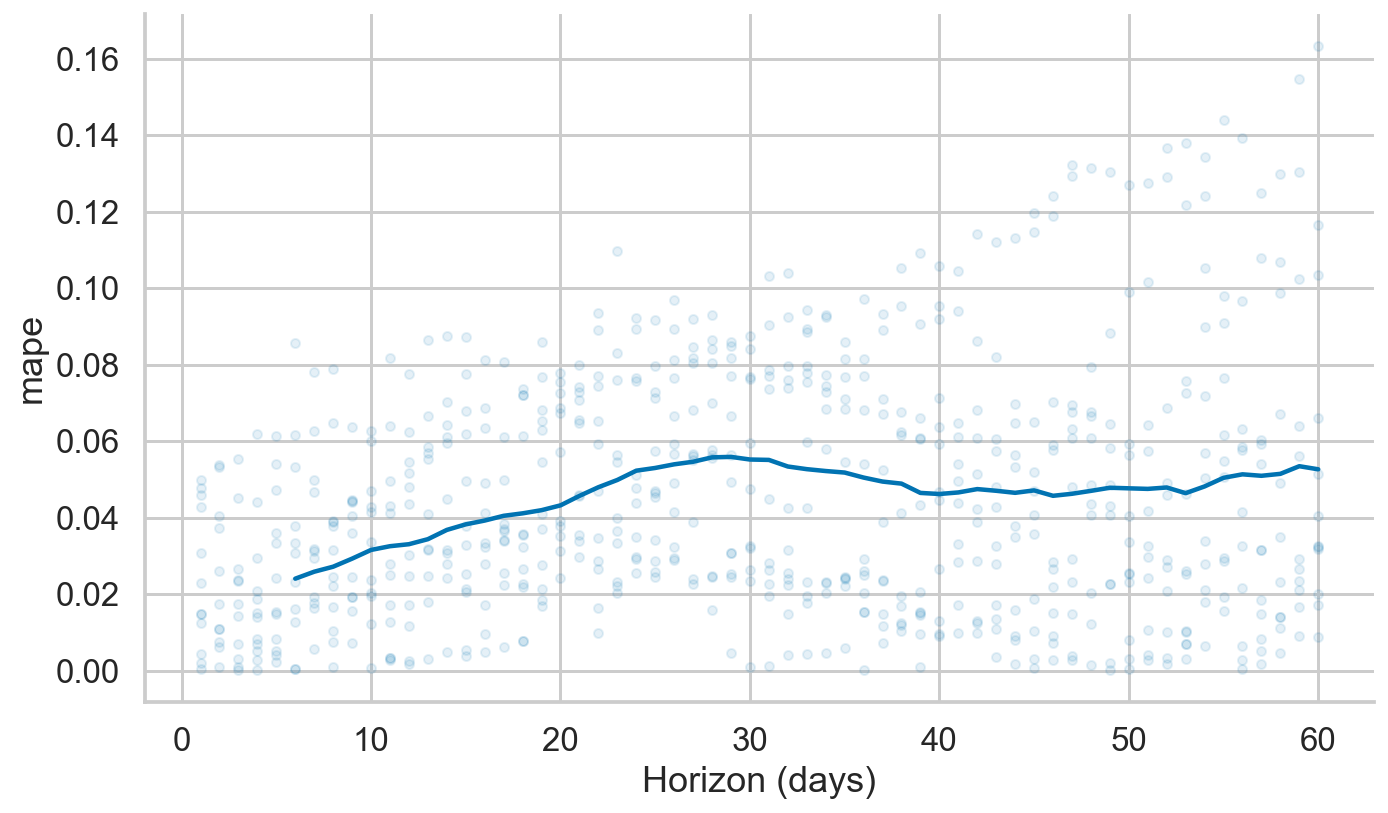

In [27]:
plot_cross_validation_metric(df_cv, metric="mape")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_38")

## 7.5 AutoML for time series forecasting with PyCaret

### Getting ready

1. Import the libraries and authenticate:

In [3]:
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

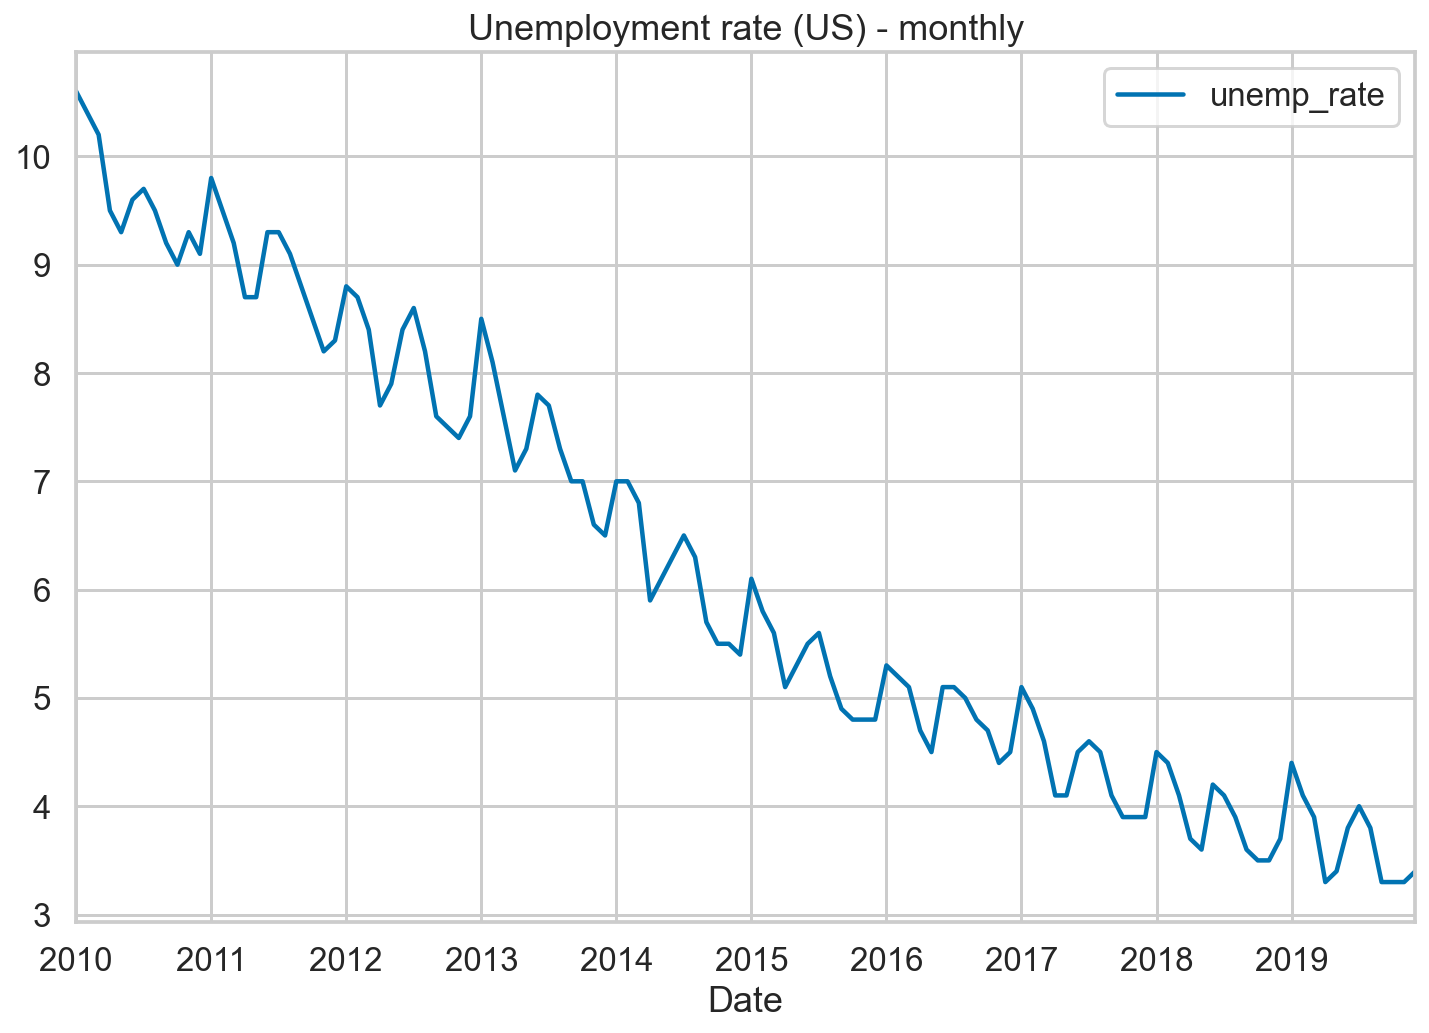

In [4]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
df.plot(title="Unemployment rate (US) - monthly");

### How to do it...

1. Import the libraries:

In [5]:
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

2. Set up the experiment:

In [6]:
exp = TSForecastingExperiment()
exp.setup(df, fh=6, fold=5, session_id=42)

3. Explore the time series using visualizations:

In [7]:
exp.plot_model(
    plot="diagnostics", 
    fig_kwargs={"height": 800, "width": 1000}
)

In [8]:
exp.plot_model(plot="cv")

Some additional plots:

In [9]:
exp.plot_model(plot="ts")

In [10]:
exp.plot_model(plot="acf")

In [11]:
exp.plot_model(plot="decomp_stl")

In [12]:
exp.plot_model(plot="periodogram")

In [13]:
exp.plot_model(plot="fft")

4. Run statistical tests on the time series:

In [14]:
exp.check_stats()

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting        Value  
0                                   120.0  
1                                     0.0  
2                                   6.225  
3                                     5.6  
4                                 2.10223  
5                                 4.41937  
6                               -1.232708  
7                                0.345242  
8                                    59.0  
9   {'alpha': 0.05, 'K': 24}  1610.583379  
10  {'alpha': 0.05, 'K': 48}  1778.242684  
11  {'alpha': 0.05, 'K': 24}          0.0  
12  {'alpha': 0.05, 'K': 48}          0.0  
13  {'alpha': 0.05, 'K': 24}        False  
14  {'alpha': 0.05, 'K': 48}        False  
15           {'alpha': 0.05}        False  
16           {'alpha': 0.05}     0.263656  
17           {'alpha': 0.05}    -2.053411  
18           {'alpha': 0.05}    -3.492996  
19           {'alpha': 0.05}    -2.888955  
20           {'alpha': 0.05}    -2.581393  
21           {'alpha': 0.05}        False  
22           {'alpha': 0.05}         0.01  
23           {'alpha': 0.05}      0.44361  
24           {'alpha': 0.05}        0.119  
25           {'alpha': 0.05}        0.146  
26           {'alpha': 0.05}        0.176  
27           {'alpha': 0.05}        0.216  
28           {'alpha': 0.05}        False  
29           {'alpha': 0.05}     0.000005

In [15]:
exp.check_stats(test="summary")

Test   Test Name         Data            Property Setting       Value
0  Summary  Statistics  Transformed              Length          120.000000
1  Summary  Statistics  Transformed    # Missing Values            0.000000
2  Summary  Statistics  Transformed                Mean            6.225000
3  Summary  Statistics  Transformed              Median            5.600000
4  Summary  Statistics  Transformed  Standard Deviation            2.102230
5  Summary  Statistics  Transformed            Variance            4.419370
6  Summary  Statistics  Transformed            Kurtosis           -1.232708
7  Summary  Statistics  Transformed            Skewness            0.345242
8  Summary  Statistics  Transformed   # Distinct Values           59.000000

5. Find the five best fitting pipelines:

In [16]:
best_pipelines = exp.compare_models(
    sort="MAPE", turbo=False, n_select=5
)

Processing:   0%|          | 0/141 [00:00<?, ?it/s]

In [17]:
best_pipelines

[BATS(show_warnings=False, sp=12, use_box_cox=True),
 TBATS(show_warnings=False, sp=[12], use_box_cox=True),
 AutoARIMA(random_state=42, sp=12, suppress_warnings=True),
 ProphetPeriodPatched(),
 ThetaForecaster(sp=12)]

In [18]:
# recover the DataFrame with the metrics
compare_metrics_base = exp.pull()
compare_metrics_base

Model    MASE  \
bats                                                          BATS  0.1222   
tbats                                                        TBATS  0.1308   
auto_arima                                              Auto ARIMA  0.1487   
prophet                                                    Prophet  0.1599   
theta                                             Theta Forecaster  0.1802   
ets                                                            ETS  0.1976   
exp_smooth                                   Exponential Smoothing  0.2074   
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...  0.2118   
arima                                                        ARIMA  0.2453   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending  0.2516   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending  0.2524   
et_cds_dt          Extra Trees w/ Cond. Deseasonalize & Detrending  0.2726   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...  0.2715   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending  0.2915   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending  0.3052   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending  0.3063   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending  0.3072   
lar_cds_dt       Least Angular Regressor w/ Cond. Deseasonalize...  0.3288   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending   0.339   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...  0.3448   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...  0.3563   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...  0.3603   
catboost_cds_dt  CatBoost Regressor w/ Cond. Deseasonalize & De...  0.3825   
naive                                             Naive Forecaster  0.5032   
snaive                                   Seasonal Naive Forecaster  0.5834   
croston                                                    Croston  0.6327   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending  0.7809   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending  0.7809   
llar_cds_dt      Lasso Least Angular Regressor w/ Cond. Deseaso...  0.7809   
polytrend                              Polynomial Trend Forecaster  0.8269   
par_cds_dt       Passive Aggressive w/ Cond. Deseasonalize & De...  1.3195   
grand_means                                 Grand Means Forecaster  3.7084   

                  RMSSE     MAE    RMSE    MAPE   SMAPE       R2  TT (Sec)  
bats             0.1364  0.0911  0.1105  0.0225  0.0227   0.8702     1.956  
tbats             0.141  0.0976  0.1142  0.0239  0.0242   0.8641     4.742  
auto_arima       0.1626   0.111  0.1319   0.028  0.0287   0.7229     2.650  
prophet          0.1675  0.1201  0.1364  0.0293  0.0294   0.8053     0.842  
theta            0.1906  0.1348  0.1547  0.0332  0.0332   0.7221     0.008  
ets              0.2108  0.1474  0.1708  0.0358  0.0364   0.6639     0.016  
exp_smooth       0.2256  0.1547  0.1828  0.0371  0.0381   0.6565     0.022  
xgboost_cds_dt    0.251  0.1608  0.2056   0.039  0.0403   0.4461     0.020  
arima            0.2573  0.1833  0.2088  0.0462  0.0477   0.4979     0.040  
lr_cds_dt        0.2635  0.1907  0.2163  0.0465  0.0481   0.4679     0.040  
huber_cds_dt     0.2662  0.1914  0.2185  0.0466  0.0482   0.4544     0.012  
et_cds_dt        0.2918  0.2087  0.2411  0.0497  0.0519   0.2802     0.034  
br_cds_dt        0.2828  0.2056  0.2319  0.0501  0.0519   0.3964     0.010  
ridge_cds_dt     0.3005  0.2202   0.246   0.054   0.056   0.3315     0.012  
rf_cds_dt        0.3161  0.2322  0.2603  0.0558  0.0582   0.2598     0.036  
ada_cds_dt       0.3214  0.2333  0.2647  0.0566   0.059   0.1843     0.020  
dt_cds_dt        0.3163  0.2326  0.2593  0.0567  0.0584   0.2933     0.010  
lar_cds_dt       0.3381  0.2503  0.2786  0.0607  0.0634   0.0918     0.012  
knn_cds_dt        0.341

In [19]:
# inspect the available models
exp.models()

Name  \
ID                                                                   
naive                                             Naive Forecaster   
grand_means                                 Grand Means Forecaster   
snaive                                   Seasonal Naive Forecaster   
polytrend                              Polynomial Trend Forecaster   
arima                                                        ARIMA   
auto_arima                                              Auto ARIMA   
exp_smooth                                   Exponential Smoothing   
croston                                                    Croston   
ets                                                            ETS   
theta                                             Theta Forecaster   
tbats                                                        TBATS   
bats                                                          BATS   
prophet                                                    Prophet   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending   
lar_cds_dt       Least Angular Regressor w/ Cond. Deseasonalize...   
llar_cds_dt      Lasso Least Angular Regressor w/ Cond. Deseaso...   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending   
par_cds_dt       Passive Aggressive w/ Cond. Deseasonalize & De...   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending   
et_cds_dt          Extra Trees w/ Cond. Deseasonalize & Detrending   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending   
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...   
catboost_cds_dt  CatBoost Regressor w/ Cond. Deseasonalize & De...   

                                                         Reference  Turbo  
ID                                                                         
naive                     sktime.forecasting.naive.NaiveForecaster   True  
grand_means               sktime.forecasting.naive.NaiveForecaster   True  
snaive                    sktime.forecasting.naive.NaiveForecaster   True  
polytrend        sktime.forecasting.trend.PolynomialTrendForeca...   True  
arima                               sktime.forecasting.arima.ARIMA   True  
auto_arima                      sktime.forecasting.arima.AutoARIMA   True  
exp_smooth       sktime.forecasting.exp_smoothing.ExponentialSm...   True  
croston                         sktime.forecasting.croston.Croston   True  
ets                                 sktime.forecasting.ets.AutoETS   True  
theta                     sktime.forecasting.theta.ThetaForecaster   True  
tbats                               sktime.forecasting.tbats.TBATS  False  
bats                                  sktime.forecasting.bats.BATS  False  
prophet          pycaret.containers.models.time_series.ProphetP...  False  
lr_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
en_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
ridge_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
lasso_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
lar_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
llar_cds_dt      pycaret.containers.models.time_series.BaseCdsD...   True  
br_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
huber_cds

6. Tune the best pipelines:

In [20]:
best_pipelines_tuned = [exp.tune_model(model) for model in best_pipelines]
best_pipelines_tuned

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.6s finished


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.3s finished


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   24.9s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.2s finished


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


[BATS(show_warnings=False, sp=12, use_box_cox=True),
 TBATS(show_warnings=False, sp=[12], use_box_cox=True, use_damped_trend=True,
       use_trend=True),
 AutoARIMA(random_state=42, sp=12, suppress_warnings=True),
 ProphetPeriodPatched(changepoint_prior_scale=0.016439324494196616,
                      holidays_prior_scale=0.01095960453692584,
                      seasonality_prior_scale=7.886714129990491),
 ThetaForecaster(sp=12)]

7. Blend the 5 tuned pipelines:

In [21]:
blended_model = exp.blend_models(
    best_pipelines_tuned, method="mean"
)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

8. Create the predictions using the blended model and plot the forecasts:

In [22]:
y_pred = exp.predict_model(blended_model)

In [23]:
exp.plot_model(estimator=blended_model)

9. Finalize the model:

In [24]:
final_model = exp.finalize_model(blended_model)
exp.plot_model(final_model)

In [25]:
y_pred = exp.predict_model(final_model)
print(y_pred)

         y_pred
2020-01  3.8437
2020-02  3.6852
2020-03  3.4731
2020-04  3.0444
2020-05  3.0711
2020-06  3.4585
